# CBiGANによる異常検知

In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import os
import re
import pathlib
import h5py
import joblib
import shutil
import matplotlib.pyplot as plt
import glob
import wave
import tensorflow as tf

from audio_processing.librosa_compute_spectrogram import wav_to_spectrogram
from utils.data_loader import return_dataset_loader
from train import Train_Pipeline
from test import test
from utils import visualization
from utils import validate

In [2]:
# モジュールのオートリロード用のコマンド
%load_ext autoreload
%autoreload 2

## MLflowのexperimentとRunを設定
ログが置かれたディレクトリを指定して以下のコマンドを実行(mlflowの環境下で実行)

mlflow ui --backend-store-uri /path/to/uri --port 5000

In [3]:
import mlflow
from pathlib import Path

# フォルダが存在しない場合に作成
mlruns_folder = Path('./mlruns')
mlruns_folder.mkdir(parents=True, exist_ok=True)

# trackingの絶対パスを指定
TRACKING_URI = mlruns_folder.resolve()

EXPERIMENT_NAME ="CBiGAN"

# トラッキングサーバ（バックエンド）の場所を指定
mlflow.set_tracking_uri(TRACKING_URI)

# Experimentの生成
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:  # 当該Experiment存在しないとき、新たに作成
    experiment_id = mlflow.create_experiment(
        name=EXPERIMENT_NAME
    )
else: # 当該Experiment存在するとき、IDを取得
    experiment_id = experiment.experiment_id


# Runを設定
RUN_NAME = 'CBiGAN'
TAGS={
    'version':'1',
}
description='Anomaly detection by CBiGAN'

# RUNを実行
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME, tags=TAGS, description=description) as run:
    MLFLOW_RUN_ID = run.info.run_id
    
print("Experiment ID:", experiment_id)
print("Run ID:", MLFLOW_RUN_ID)
print("============================")

# ライフサイクルがdeletedになっているrunを削除（ストレージにrunが蓄積してしまうため）
relative_path = TRACKING_URI.relative_to(Path.cwd())
! mlflow gc --backend-store-uri $relative_path

Experiment ID: 0
Run ID: e1db54c3a9b949c19920f0ef02a873d6


## Tensor BoardのSummaryWriterを定義
以下のコマンドを実行

tensorboard --logdir /path/to/logfolder

In [4]:
import datetime

# Tensor Board
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'TBruns/{current_time}/MLFLOW_RUN_ID_{MLFLOW_RUN_ID}'
SUMMARY_WRITER = tf.summary.create_file_writer(log_dir)

In [5]:
# %load_ext tensorboard
# %tensorboard --logdir logs

訓練データのパスを定義

In [6]:
'''
testdata : '210921_0032.wav' # 最終的な性能を評価するためのデータ
valdata : '210922_0033.wav' # 閾値などを検討する際に使用するデータ
'''
datas_dir = pathlib.Path('../../data/16000hz騒音データとスタートを合わせた音データ')
label_data_dir = pathlib.Path('../../data/学習データ(オリジナル)/')

all_traindata = [datas_dir/'210919_0031.wav', datas_dir/'210923_0034.wav', datas_dir/'210924_0035.wav']
print(all_traindata)

[WindowsPath('../../data/16000hz騒音データとスタートを合わせた音データ/210919_0031.wav'), WindowsPath('../../data/16000hz騒音データとスタートを合わせた音データ/210923_0034.wav'), WindowsPath('../../data/16000hz騒音データとスタートを合わせた音データ/210924_0035.wav')]


各要素をラベルのDFとするリストを定義

In [7]:
label_data_dir = pathlib.Path('../../data/学習データ(オリジナル)/')
# label_data_dir = pathlib.Path('../../data/プログラム確認用音声データ/label')

# ラベルのDFを作成
list_df_labelData =[]
for i in all_traindata:
#     label_data_name = i.split('/')[-1].replace('.wav', '.csv') 
    labelData_name = i.with_suffix('.csv').name
    labelData_file = label_data_dir/labelData_name
    df_labelData=pd.read_csv(labelData_file, skiprows=4, usecols=[1], header=None) 
    list_df_labelData.append(df_labelData)

# display(list_df_labelData[0])

パラメータ

In [8]:
# スペクトログラムのパラメータ
SR = 16000 # サンプリング周波数
DURATION = 1 # スペクトログラムの時間幅[s]
# SPEC_PARAMS = {'frame_length':2048, 'frame_step':400} # スペクトログラムのパラメータ
MEL_PAEAMS = {'sr':SR, 'n_fft':2048, 'hop_length':500, 'n_mels':64, 'fmax':SR/2, 'fmin':80} # メル尺度のパラメータ
# npy関係のファイルを出力するフォルダ
NPY_OUTPUT = './data_output/npy/train'

IMAGE_SIZE = [64, 64, 3] # [w, h, c]
VAL_RATE = 0.1  # 全データに対するバリデーションデータの割合
LATENT_SIZE = 64  # 潜在変数zの次元数
BATCH_SIZE = 256 # バッチサイズ
EPOCHS = 500  # エポック数
G_E_LR = 0.0004  # 学習率
D_LR = 0.0004  # 学習率
GP_WEIGHT = 10.0 # gradient_penaltyの重み
ALPHA = 0.01 #損失関数におけるL1 Lossの割合

適用するデータ拡張を指定 

In [9]:
TRANSFORM_NAME = [
    'GaussianNoiseSNR',
    'PinkNoiseSNR',
    'PitchShift',
    'TimeShift',
    'VolumeShift',
]

In [10]:
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_params(
        {
            "SR":SR,
            "DURATION":DURATION,
            "MEL_PAEAMS":MEL_PAEAMS,
            "IMAGE_SIZE":IMAGE_SIZE,
            "BATCH_SIZE":BATCH_SIZE,
            "EPOCHS":EPOCHS,
            "G_ELearningRate":G_E_LR,
            "D_LearningRate":D_LR,
            "LATENT_SIZE":LATENT_SIZE,
            "ALPHA":ALPHA,
            "TRANSFORM_NAME":TRANSFORM_NAME
        }
    )
#########################

メルスペクトログラムに変換

In [11]:
%%time
train_mean, train_std  = wav_to_spectrogram(NPY_OUTPUT,all_traindata, SR, DURATION,MEL_PAEAMS, TRANSFORM_NAME, list_df_labelData, 
                                            overwrite=False)

npy_output: data_output\npy\train\npy_files
data_output\npy\trainが既に存在します
上書せずに終了
Wall time: 2.01 ms


標準化のための平均値と標準偏差を訓練データから算出。テストデータの標準化にも使用

In [12]:
print(f'平均値：{train_mean}')
print(f'標準偏差：{train_std}')

平均値：-40.24698257446289
標準偏差：10.34200668334961


データセットの定義

In [13]:
# 訓練データを訓練データとバリデーションデータに分割
list_train_npyFiles = glob.glob(f'{NPY_OUTPUT}/npy_files/*')

list_train_npyFiles = list_train_npyFiles[:50000]


num_all_data = len(list_train_npyFiles)
print('全データ数:', num_all_data)

index_array = np.array(range(num_all_data))
np.random.shuffle(index_array)
num_train_data = int(num_all_data*(1-VAL_RATE))
idx_train_data = index_array[:num_train_data]
idx_val_data = index_array[num_train_data:]
print('全データ×(1-VAL_RATE):', num_train_data)

train_npyFiles = [list_train_npyFiles[idx] for idx in idx_train_data]
val_npyFiles = [list_train_npyFiles[idx] for idx in idx_val_data]
print('訓練データ数：',len(train_npyFiles))
print('valデータ数：',len(val_npyFiles)) 

# データセット
train_dataset = return_dataset_loader(train_npyFiles,
                                      [IMAGE_SIZE[0], IMAGE_SIZE[1]],
                                      mean=train_mean, 
                                      std=train_std, 
                                      training=True, 
                                      batch_size=BATCH_SIZE)
val_dataset = return_dataset_loader(val_npyFiles, 
                                    [IMAGE_SIZE[0], IMAGE_SIZE[1]],
                                    mean=train_mean, 
                                    std=train_std, 
                                    training=True, 
                                    batch_size=BATCH_SIZE)

ITERATION = int(train_dataset.cardinality())
print(f"batch size:{BATCH_SIZE}")
print(f"iteration:{ITERATION}")

全データ数: 50000
全データ×(1-VAL_RATE): 45000
訓練データ数： 45000
valデータ数： 5000
batch size:256
iteration:176


In [17]:
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_params(
        {
            "train_mean":train_mean,
            "train_std":train_std,
            "Number of train data":num_all_data,
            "iteration":ITERATION
        }
    )
#########################

# 訓練

In [18]:
# 実行時のスクリプトを保存
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_artifact("Anomalydetection.ipynb", artifact_path="source_code")
    mlflow.log_artifact("./model/CBiGAN.py", artifact_path="source_code/model")
########################

In [19]:
# モデルの定義
from model.CBiGAN import Encoder, Generator, Discriminator

In [20]:
def get_model(latent_size, g_e_lr, d_lr, iteration, channels):
    # model
    E = Encoder(latent_size=latent_size)
    G = Generator(latent_size=latent_size, channels=channels)
    D = Discriminator(latent_size=latent_size)
    
    # optimizer
    ## GとEのoptimizer用のスケジューラ
    lr_schedule_ge = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=g_e_lr,
        decay_steps=50*iteration, # 50エポックごとに減衰
        decay_rate=0.96,
        staircase=True)
    ## Dのoptimizer用のスケジューラ
    lr_schedule_d = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=d_lr,
        decay_steps=50*iteration,
        decay_rate=0.96,
        staircase=True)
    G_E_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_ge, beta_1=0.5, beta_2=0.999)
    D_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_d, beta_1=0.5, beta_2=0.999)
    
    return E, G, D, G_E_optimizer, D_optimizer

In [21]:
encoder, generator, discriminator, G_E_optimizer, D_optimizer = get_model(LATENT_SIZE, G_E_LR, D_LR, ITERATION, IMAGE_SIZE[2]) 

In [22]:
model = encoder.get_functionalModel(input_shape=IMAGE_SIZE)
model.summary()

Model: "functionalModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
layer_in (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder_block_1 (EncoderBlock)  (None, 32, 32, 4)    600         layer_in[0][0]                   
__________________________________________________________________________________________________
encoder_block_2 (EncoderBlock)  (None, 16, 16, 8)    2112        encoder_block_1[0][0]            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 8, 8, 16)     2048        encoder_block_2[0][0]            
____________________________________________________________________________________

In [23]:
functional_generator = generator.get_functionalModel(input_shape=(LATENT_SIZE))
functional_generator.summary()

Model: "functionalModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
layer_in (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
generator_reshape_1 (Reshape)   (None, 1, 1, 64)     0           layer_in[0][0]                   
__________________________________________________________________________________________________
conv2DTranspose1 (Conv2DTranspo (None, 2, 2, 256)    65792       generator_reshape_1[0][0]        
__________________________________________________________________________________________________
generator_batchNorm1 (BatchNorm (None, 2, 2, 256)    1024        conv2DTranspose1[0][0]           
____________________________________________________________________________________

In [24]:
functional_discriminator = discriminator.get_functionalModel(input_shape=[IMAGE_SIZE, LATENT_SIZE])
functional_discriminator.summary()

Model: "functionalModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
layer_in_x (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
discriminator_block_1 (EncoderB (None, 32, 32, 8)    1968        layer_in_x[0][0]                 
__________________________________________________________________________________________________
discriminator_dropout (SpatialD multiple             0           leaky_re_lu_6[0][0]              
                                                                 discriminator_block_1[0][0]      
                                                                 discriminator_block_2[0][0]      
                                                                 leaky_re_lu_6[5][0]

In [25]:
# checkpoint
dir_checkpoint = f'./data_output/tf_ckpts/{MLFLOW_RUN_ID}'
step_epoch=tf.Variable(1)
ckpt = tf.train.Checkpoint(
    step=step_epoch,
    encoder=encoder,
    generator=generator,
    discriminator=discriminator,
    G_E_optimizer=G_E_optimizer,
    D_optimizer=D_optimizer)
manager = tf.train.CheckpointManager(ckpt, dir_checkpoint, max_to_keep=2) # サイズが大きいためなるべく少なく

In [26]:
TP = Train_Pipeline(SUMMARY_WRITER, GP_WEIGHT, ALPHA)
history = TP.train(encoder, generator, discriminator, G_E_optimizer, D_optimizer, EPOCHS, BATCH_SIZE, LATENT_SIZE, train_dataset, val_dataset, ckpt, manager)


start of epoch 0


Epoch[0/500]: 100%|██████| 176/176 [04:35<00:00,  1.56s/batch, G_E_loss=1041.09, D_loss=4.46e+3, anomaly_score=1.66e+5]


0/500 Epoch G_E_loss: 1041.090 D_loss: 4456.781 anomaly_score: 166079.266 val_anomaly_score: 88311.609
Saved checkpoint for step 2: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-1

start of epoch 1


Epoch[1/500]: 100%|███████████████| 176/176 [02:34<00:00,  1.14batch/s, G_E_loss=612, D_loss=129, anomaly_score=7.2e+4]


1/500 Epoch G_E_loss: 611.601 D_loss: 129.416 anomaly_score: 71962.719 val_anomaly_score: 62305.195
Saved checkpoint for step 3: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-2

start of epoch 2


Epoch[2/500]: 100%|███████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=568, D_loss=49, anomaly_score=6.77e+4]


2/500 Epoch G_E_loss: 567.945 D_loss: 48.958 anomaly_score: 67665.055 val_anomaly_score: 66770.008

start of epoch 3


Epoch[3/500]: 100%|█████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=546, D_loss=23.5, anomaly_score=6.82e+4]


3/500 Epoch G_E_loss: 545.517 D_loss: 23.451 anomaly_score: 68192.180 val_anomaly_score: 62476.461

start of epoch 4


Epoch[4/500]: 100%|█████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=534, D_loss=13.1, anomaly_score=6.63e+4]


4/500 Epoch G_E_loss: 533.795 D_loss: 13.126 anomaly_score: 66319.266 val_anomaly_score: 65527.117

start of epoch 5


Epoch[5/500]: 100%|█████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=525, D_loss=7.48, anomaly_score=7.17e+4]


5/500 Epoch G_E_loss: 525.011 D_loss: 7.480 anomaly_score: 71691.992 val_anomaly_score: 65738.141

start of epoch 6


Epoch[6/500]: 100%|█████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=518, D_loss=4.21, anomaly_score=7.28e+4]


6/500 Epoch G_E_loss: 518.494 D_loss: 4.213 anomaly_score: 72784.719 val_anomaly_score: 74126.367

start of epoch 7


Epoch[7/500]: 100%|██████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=514, D_loss=2.18, anomaly_score=7.5e+4]


7/500 Epoch G_E_loss: 513.704 D_loss: 2.183 anomaly_score: 74951.930 val_anomaly_score: 71823.273

start of epoch 8


Epoch[8/500]: 100%|█████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=522, D_loss=3.03, anomaly_score=8.01e+4]


8/500 Epoch G_E_loss: 521.922 D_loss: 3.031 anomaly_score: 80054.922 val_anomaly_score: 57909.750
Saved checkpoint for step 10: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-3

start of epoch 9


Epoch[9/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=509, D_loss=0.755, anomaly_score=6.31e+4]


9/500 Epoch G_E_loss: 508.560 D_loss: 0.755 anomaly_score: 63101.516 val_anomaly_score: 69937.078

start of epoch 10


Epoch[10/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=503, D_loss=-.177, anomaly_score=7.31e+4]


10/500 Epoch G_E_loss: 503.441 D_loss: -0.177 anomaly_score: 73105.688 val_anomaly_score: 68478.969

start of epoch 11


Epoch[11/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=506, D_loss=-.471, anomaly_score=70318.5]


11/500 Epoch G_E_loss: 506.005 D_loss: -0.471 anomaly_score: 70318.500 val_anomaly_score: 66756.492

start of epoch 12


Epoch[12/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=499, D_loss=-.773, anomaly_score=7.03e+4]


12/500 Epoch G_E_loss: 498.763 D_loss: -0.773 anomaly_score: 70271.547 val_anomaly_score: 73378.953

start of epoch 13


Epoch[13/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=494, D_loss=-.672, anomaly_score=6.95e+4]


13/500 Epoch G_E_loss: 493.680 D_loss: -0.672 anomaly_score: 69473.781 val_anomaly_score: 70426.859

start of epoch 14


Epoch[14/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=492, D_loss=-.659, anomaly_score=6.59e+4]


14/500 Epoch G_E_loss: 492.280 D_loss: -0.659 anomaly_score: 65946.156 val_anomaly_score: 62116.656

start of epoch 15


Epoch[15/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=489, D_loss=-.709, anomaly_score=62895.6]


15/500 Epoch G_E_loss: 489.186 D_loss: -0.709 anomaly_score: 62895.602 val_anomaly_score: 56607.914
Saved checkpoint for step 17: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-4

start of epoch 16


Epoch[16/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=486, D_loss=-.696, anomaly_score=5.89e+4]


16/500 Epoch G_E_loss: 485.978 D_loss: -0.696 anomaly_score: 58942.777 val_anomaly_score: 53713.324
Saved checkpoint for step 18: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-5

start of epoch 17


Epoch[17/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=484, D_loss=-.765, anomaly_score=5.84e+4]


17/500 Epoch G_E_loss: 484.360 D_loss: -0.765 anomaly_score: 58420.938 val_anomaly_score: 56453.668

start of epoch 18


Epoch[18/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=483, D_loss=-.88, anomaly_score=5.65e+4]


18/500 Epoch G_E_loss: 483.318 D_loss: -0.880 anomaly_score: 56461.512 val_anomaly_score: 54733.531

start of epoch 19


Epoch[19/500]: 100%|█████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=481, D_loss=-.9, anomaly_score=5.48e+4]


19/500 Epoch G_E_loss: 481.261 D_loss: -0.900 anomaly_score: 54824.227 val_anomaly_score: 53828.137

start of epoch 20


Epoch[20/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=480, D_loss=-.895, anomaly_score=5.44e+4]


20/500 Epoch G_E_loss: 479.695 D_loss: -0.895 anomaly_score: 54366.227 val_anomaly_score: 52319.102
Saved checkpoint for step 22: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-6

start of epoch 21


Epoch[21/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=477, D_loss=-.974, anomaly_score=5.34e+4]


21/500 Epoch G_E_loss: 477.186 D_loss: -0.974 anomaly_score: 53433.160 val_anomaly_score: 50920.734
Saved checkpoint for step 23: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-7

start of epoch 22


Epoch[22/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=479, D_loss=-1.12, anomaly_score=5.24e+4]


22/500 Epoch G_E_loss: 479.055 D_loss: -1.122 anomaly_score: 52423.234 val_anomaly_score: 52928.711

start of epoch 23


Epoch[23/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=477, D_loss=-1.26, anomaly_score=5.37e+4]


23/500 Epoch G_E_loss: 476.574 D_loss: -1.259 anomaly_score: 53660.465 val_anomaly_score: 54324.988

start of epoch 24


Epoch[24/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=501, D_loss=-3.7, anomaly_score=6.79e+4]


24/500 Epoch G_E_loss: 500.865 D_loss: -3.703 anomaly_score: 67943.320 val_anomaly_score: 51061.633

start of epoch 25


Epoch[25/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=478, D_loss=6.42, anomaly_score=5.24e+4]


25/500 Epoch G_E_loss: 477.806 D_loss: 6.425 anomaly_score: 52432.566 val_anomaly_score: 49817.512
Saved checkpoint for step 27: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-8

start of epoch 26


Epoch[26/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=475, D_loss=-1.99, anomaly_score=5.16e+4]


26/500 Epoch G_E_loss: 474.869 D_loss: -1.995 anomaly_score: 51570.465 val_anomaly_score: 49861.332

start of epoch 27


Epoch[27/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=472, D_loss=-1.81, anomaly_score=49912.8]


27/500 Epoch G_E_loss: 472.202 D_loss: -1.809 anomaly_score: 49912.801 val_anomaly_score: 45927.426
Saved checkpoint for step 29: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-9

start of epoch 28


Epoch[28/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=471, D_loss=-1.71, anomaly_score=4.93e+4]


28/500 Epoch G_E_loss: 470.696 D_loss: -1.712 anomaly_score: 49318.086 val_anomaly_score: 46708.863

start of epoch 29


Epoch[29/500]: 100%|███████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=469, D_loss=-1.49, anomaly_score=4.88e+4]


29/500 Epoch G_E_loss: 469.325 D_loss: -1.495 anomaly_score: 48790.441 val_anomaly_score: 45529.660
Saved checkpoint for step 31: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-10

start of epoch 30


Epoch[30/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=469, D_loss=-1.56, anomaly_score=4.86e+4]


30/500 Epoch G_E_loss: 469.101 D_loss: -1.556 anomaly_score: 48601.535 val_anomaly_score: 45364.961
Saved checkpoint for step 32: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-11

start of epoch 31


Epoch[31/500]: 100%|████████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=468, D_loss=-1.52, anomaly_score=4.8e+4]


31/500 Epoch G_E_loss: 467.939 D_loss: -1.524 anomaly_score: 48020.227 val_anomaly_score: 45859.289

start of epoch 32


Epoch[32/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=467, D_loss=-1.48, anomaly_score=4.76e+4]


32/500 Epoch G_E_loss: 467.026 D_loss: -1.484 anomaly_score: 47612.277 val_anomaly_score: 44507.023
Saved checkpoint for step 34: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-12

start of epoch 33


Epoch[33/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=475, D_loss=-3.64, anomaly_score=5.19e+4]


33/500 Epoch G_E_loss: 475.328 D_loss: -3.637 anomaly_score: 51901.141 val_anomaly_score: 46746.855

start of epoch 34


Epoch[34/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=466, D_loss=-2.55, anomaly_score=4.71e+4]


34/500 Epoch G_E_loss: 465.847 D_loss: -2.549 anomaly_score: 47081.129 val_anomaly_score: 46683.691

start of epoch 35


Epoch[35/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=464, D_loss=-1.74, anomaly_score=46872.1]


35/500 Epoch G_E_loss: 464.259 D_loss: -1.742 anomaly_score: 46872.102 val_anomaly_score: 47102.477

start of epoch 36


Epoch[36/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=464, D_loss=-1.63, anomaly_score=4.64e+4]


36/500 Epoch G_E_loss: 463.744 D_loss: -1.632 anomaly_score: 46440.984 val_anomaly_score: 43529.773
Saved checkpoint for step 38: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-13

start of epoch 37


Epoch[37/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=462, D_loss=-1.51, anomaly_score=4.58e+4]


37/500 Epoch G_E_loss: 461.641 D_loss: -1.514 anomaly_score: 45841.293 val_anomaly_score: 48506.906

start of epoch 38


Epoch[38/500]: 100%|████████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=460, D_loss=12.3, anomaly_score=4.58e+4]


38/500 Epoch G_E_loss: 459.640 D_loss: 12.261 anomaly_score: 45838.613 val_anomaly_score: 43343.699
Saved checkpoint for step 40: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-14

start of epoch 39


Epoch[39/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=459, D_loss=-1.16, anomaly_score=4.6e+4]


39/500 Epoch G_E_loss: 459.258 D_loss: -1.160 anomaly_score: 46025.223 val_anomaly_score: 43944.020

start of epoch 40


Epoch[40/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=459, D_loss=-1.25, anomaly_score=4.58e+4]


40/500 Epoch G_E_loss: 459.274 D_loss: -1.254 anomaly_score: 45798.211 val_anomaly_score: 45936.504

start of epoch 41


Epoch[41/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=457, D_loss=-1.18, anomaly_score=45429.5]


41/500 Epoch G_E_loss: 457.291 D_loss: -1.184 anomaly_score: 45429.500 val_anomaly_score: 43386.582

start of epoch 42


Epoch[42/500]: 100%|███████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=459, D_loss=-1.43, anomaly_score=4.72e+4]


42/500 Epoch G_E_loss: 459.333 D_loss: -1.426 anomaly_score: 47153.914 val_anomaly_score: 42359.391
Saved checkpoint for step 44: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-15

start of epoch 43


Epoch[43/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=456, D_loss=-1.33, anomaly_score=4.51e+4]


43/500 Epoch G_E_loss: 456.274 D_loss: -1.326 anomaly_score: 45102.688 val_anomaly_score: 44317.941

start of epoch 44


Epoch[44/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=455, D_loss=-.973, anomaly_score=4.48e+4]


44/500 Epoch G_E_loss: 455.025 D_loss: -0.973 anomaly_score: 44820.629 val_anomaly_score: 42407.477

start of epoch 45


Epoch[45/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=454, D_loss=-1.12, anomaly_score=4.43e+4]


45/500 Epoch G_E_loss: 454.234 D_loss: -1.125 anomaly_score: 44334.312 val_anomaly_score: 43037.523

start of epoch 46


Epoch[46/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=455, D_loss=-1.11, anomaly_score=4.44e+4]


46/500 Epoch G_E_loss: 455.420 D_loss: -1.110 anomaly_score: 44387.953 val_anomaly_score: 42735.664

start of epoch 47


Epoch[47/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=455, D_loss=-1.04, anomaly_score=4.42e+4]


47/500 Epoch G_E_loss: 454.513 D_loss: -1.042 anomaly_score: 44217.762 val_anomaly_score: 56857.707

start of epoch 48


Epoch[48/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=453, D_loss=-1.09, anomaly_score=4.41e+4]


48/500 Epoch G_E_loss: 452.580 D_loss: -1.093 anomaly_score: 44105.895 val_anomaly_score: 41957.980
Saved checkpoint for step 50: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-16

start of epoch 49


Epoch[49/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=452, D_loss=-1.01, anomaly_score=4.34e+4]


49/500 Epoch G_E_loss: 451.819 D_loss: -1.009 anomaly_score: 43434.754 val_anomaly_score: 42872.934

start of epoch 50


Epoch[50/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=453, D_loss=-.985, anomaly_score=4.36e+4]


50/500 Epoch G_E_loss: 452.884 D_loss: -0.985 anomaly_score: 43631.684 val_anomaly_score: 41290.293
Saved checkpoint for step 52: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-17

start of epoch 51


Epoch[51/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=450, D_loss=-.942, anomaly_score=4.31e+4]


51/500 Epoch G_E_loss: 450.201 D_loss: -0.942 anomaly_score: 43067.469 val_anomaly_score: 40687.574
Saved checkpoint for step 53: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-18

start of epoch 52


Epoch[52/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=452, D_loss=-.946, anomaly_score=4.31e+4]


52/500 Epoch G_E_loss: 451.778 D_loss: -0.946 anomaly_score: 43062.430 val_anomaly_score: 43340.617

start of epoch 53


Epoch[53/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=451, D_loss=-1.27, anomaly_score=4.52e+4]


53/500 Epoch G_E_loss: 451.440 D_loss: -1.271 anomaly_score: 45207.516 val_anomaly_score: 42176.887

start of epoch 54


Epoch[54/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=449, D_loss=-1.01, anomaly_score=4.15e+4]


54/500 Epoch G_E_loss: 449.316 D_loss: -1.007 anomaly_score: 41465.477 val_anomaly_score: 39833.867
Saved checkpoint for step 56: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-19

start of epoch 55


Epoch[55/500]: 100%|███████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=449, D_loss=-.829, anomaly_score=4.21e+4]


55/500 Epoch G_E_loss: 448.819 D_loss: -0.829 anomaly_score: 42092.867 val_anomaly_score: 39985.945

start of epoch 56


Epoch[56/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=449, D_loss=-.915, anomaly_score=4.32e+4]


56/500 Epoch G_E_loss: 449.238 D_loss: -0.915 anomaly_score: 43239.562 val_anomaly_score: 79898.203

start of epoch 57


Epoch[57/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=448, D_loss=-1.32, anomaly_score=4.26e+4]


57/500 Epoch G_E_loss: 448.277 D_loss: -1.321 anomaly_score: 42640.215 val_anomaly_score: 40820.586

start of epoch 58


Epoch[58/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=448, D_loss=-.858, anomaly_score=4.17e+4]


58/500 Epoch G_E_loss: 447.543 D_loss: -0.858 anomaly_score: 41681.730 val_anomaly_score: 40091.340

start of epoch 59


Epoch[59/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=446, D_loss=-.992, anomaly_score=4.21e+4]


59/500 Epoch G_E_loss: 446.446 D_loss: -0.992 anomaly_score: 42145.121 val_anomaly_score: 38893.074
Saved checkpoint for step 61: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-20

start of epoch 60


Epoch[60/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=447, D_loss=-.707, anomaly_score=4.13e+4]


60/500 Epoch G_E_loss: 447.130 D_loss: -0.707 anomaly_score: 41273.777 val_anomaly_score: 39698.906

start of epoch 61


Epoch[61/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=447, D_loss=9.46, anomaly_score=4.19e+4]


61/500 Epoch G_E_loss: 447.013 D_loss: 9.461 anomaly_score: 41892.941 val_anomaly_score: 40234.734

start of epoch 62


Epoch[62/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=447, D_loss=-.677, anomaly_score=4.25e+4]


62/500 Epoch G_E_loss: 447.234 D_loss: -0.677 anomaly_score: 42549.070 val_anomaly_score: 39326.922

start of epoch 63


Epoch[63/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=461, D_loss=-1.96, anomaly_score=5.37e+4]


63/500 Epoch G_E_loss: 461.238 D_loss: -1.960 anomaly_score: 53673.926 val_anomaly_score: 122471.836

start of epoch 64


Epoch[64/500]: 100%|██████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=476, D_loss=-13, anomaly_score=4.8e+4]


64/500 Epoch G_E_loss: 476.012 D_loss: -12.999 anomaly_score: 47987.734 val_anomaly_score: 40659.695

start of epoch 65


Epoch[65/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=457, D_loss=-6.85, anomaly_score=4.14e+4]


65/500 Epoch G_E_loss: 456.945 D_loss: -6.855 anomaly_score: 41363.934 val_anomaly_score: 40035.258

start of epoch 66


Epoch[66/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=450, D_loss=-3.76, anomaly_score=4.13e+4]


66/500 Epoch G_E_loss: 449.507 D_loss: -3.758 anomaly_score: 41316.090 val_anomaly_score: 39340.113

start of epoch 67


Epoch[67/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=445, D_loss=-.64, anomaly_score=4.16e+4]


67/500 Epoch G_E_loss: 444.591 D_loss: -0.640 anomaly_score: 41557.453 val_anomaly_score: 39899.633

start of epoch 68


Epoch[68/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=444, D_loss=-.504, anomaly_score=4.04e+4]


68/500 Epoch G_E_loss: 443.792 D_loss: -0.504 anomaly_score: 40388.105 val_anomaly_score: 38837.105
Saved checkpoint for step 70: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-21

start of epoch 69


Epoch[69/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=442, D_loss=-.649, anomaly_score=4.04e+4]


69/500 Epoch G_E_loss: 442.358 D_loss: -0.649 anomaly_score: 40414.723 val_anomaly_score: 40692.402

start of epoch 70


Epoch[70/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=443, D_loss=-.448, anomaly_score=4.07e+4]


70/500 Epoch G_E_loss: 443.023 D_loss: -0.448 anomaly_score: 40661.367 val_anomaly_score: 40598.070

start of epoch 71


Epoch[71/500]: 100%|███████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=443, D_loss=-.438, anomaly_score=4.03e+4]


71/500 Epoch G_E_loss: 442.779 D_loss: -0.438 anomaly_score: 40308.809 val_anomaly_score: 38945.551

start of epoch 72


Epoch[72/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=442, D_loss=-.515, anomaly_score=4.02e+4]


72/500 Epoch G_E_loss: 441.852 D_loss: -0.515 anomaly_score: 40247.637 val_anomaly_score: 38743.430
Saved checkpoint for step 74: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-22

start of epoch 73


Epoch[73/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=441, D_loss=-.349, anomaly_score=4.03e+4]


73/500 Epoch G_E_loss: 441.351 D_loss: -0.349 anomaly_score: 40253.879 val_anomaly_score: 39712.180

start of epoch 74


Epoch[74/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=444, D_loss=-1.87, anomaly_score=4.32e+4]


74/500 Epoch G_E_loss: 443.619 D_loss: -1.868 anomaly_score: 43197.711 val_anomaly_score: 41045.898

start of epoch 75


Epoch[75/500]: 100%|██████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=441, D_loss=-.851, anomaly_score=4e+4]


75/500 Epoch G_E_loss: 441.032 D_loss: -0.851 anomaly_score: 40046.801 val_anomaly_score: 38351.508
Saved checkpoint for step 77: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-23

start of epoch 76


Epoch[76/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=443, D_loss=-2.07, anomaly_score=4.25e+4]


76/500 Epoch G_E_loss: 443.196 D_loss: -2.071 anomaly_score: 42450.910 val_anomaly_score: 40263.113

start of epoch 77


Epoch[77/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=442, D_loss=-.688, anomaly_score=4.09e+4]


77/500 Epoch G_E_loss: 441.769 D_loss: -0.688 anomaly_score: 40905.258 val_anomaly_score: 40727.070

start of epoch 78


Epoch[78/500]: 100%|█████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=441, D_loss=-.5, anomaly_score=4.01e+4]


78/500 Epoch G_E_loss: 440.703 D_loss: -0.500 anomaly_score: 40127.586 val_anomaly_score: 40369.336

start of epoch 79


Epoch[79/500]: 100%|█████████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=445, D_loss=1.21, anomaly_score=4.3e+4]


79/500 Epoch G_E_loss: 444.793 D_loss: 1.214 anomaly_score: 42980.121 val_anomaly_score: 38557.195

start of epoch 80


Epoch[80/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=440, D_loss=-1.26, anomaly_score=3.99e+4]


80/500 Epoch G_E_loss: 440.035 D_loss: -1.256 anomaly_score: 39918.969 val_anomaly_score: 38459.535

start of epoch 81


Epoch[81/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=439, D_loss=-.528, anomaly_score=4.05e+4]


81/500 Epoch G_E_loss: 439.064 D_loss: -0.528 anomaly_score: 40538.738 val_anomaly_score: 39227.930

start of epoch 82


Epoch[82/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=441, D_loss=-1.71, anomaly_score=4.35e+4]


82/500 Epoch G_E_loss: 440.544 D_loss: -1.712 anomaly_score: 43515.723 val_anomaly_score: 40051.910

start of epoch 83


Epoch[83/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=445, D_loss=-2.82, anomaly_score=4.56e+4]


83/500 Epoch G_E_loss: 444.507 D_loss: -2.816 anomaly_score: 45613.504 val_anomaly_score: 49800.492

start of epoch 84


Epoch[84/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=451, D_loss=-1.64, anomaly_score=4.24e+4]


84/500 Epoch G_E_loss: 450.734 D_loss: -1.642 anomaly_score: 42368.125 val_anomaly_score: 40192.793

start of epoch 85


Epoch[85/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=444, D_loss=-3.97, anomaly_score=4.32e+4]


85/500 Epoch G_E_loss: 444.070 D_loss: -3.973 anomaly_score: 43214.410 val_anomaly_score: 42498.375

start of epoch 86


Epoch[86/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=439, D_loss=-.207, anomaly_score=4.12e+4]


86/500 Epoch G_E_loss: 438.633 D_loss: -0.207 anomaly_score: 41239.332 val_anomaly_score: 39419.316

start of epoch 87


Epoch[87/500]: 100%|██████████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=437, D_loss=-.513, anomaly_score=4e+4]


87/500 Epoch G_E_loss: 436.596 D_loss: -0.513 anomaly_score: 40026.621 val_anomaly_score: 39090.953

start of epoch 88


Epoch[88/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=438, D_loss=-.822, anomaly_score=4.15e+4]


88/500 Epoch G_E_loss: 437.624 D_loss: -0.822 anomaly_score: 41529.371 val_anomaly_score: 39093.453

start of epoch 89


Epoch[89/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=445, D_loss=-3.12, anomaly_score=4.44e+4]


89/500 Epoch G_E_loss: 445.336 D_loss: -3.125 anomaly_score: 44411.488 val_anomaly_score: 40923.133

start of epoch 90


Epoch[90/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=436, D_loss=-.526, anomaly_score=4.04e+4]


90/500 Epoch G_E_loss: 436.435 D_loss: -0.526 anomaly_score: 40369.363 val_anomaly_score: 38774.684

start of epoch 91


Epoch[91/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=435, D_loss=0.211, anomaly_score=3.99e+4]


91/500 Epoch G_E_loss: 434.827 D_loss: 0.211 anomaly_score: 39881.953 val_anomaly_score: 38934.727

start of epoch 92


Epoch[92/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=441, D_loss=-3.21, anomaly_score=4.36e+4]


92/500 Epoch G_E_loss: 440.924 D_loss: -3.214 anomaly_score: 43572.555 val_anomaly_score: 41157.555

start of epoch 93


Epoch[93/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=439, D_loss=-2.63, anomaly_score=4.13e+4]


93/500 Epoch G_E_loss: 439.297 D_loss: -2.630 anomaly_score: 41316.688 val_anomaly_score: 40953.582

start of epoch 94


Epoch[94/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=438, D_loss=-1.73, anomaly_score=4.22e+4]


94/500 Epoch G_E_loss: 438.418 D_loss: -1.730 anomaly_score: 42217.945 val_anomaly_score: 39504.215

start of epoch 95


Epoch[95/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=437, D_loss=-.893, anomaly_score=4.17e+4]


95/500 Epoch G_E_loss: 436.950 D_loss: -0.893 anomaly_score: 41694.109 val_anomaly_score: 38786.605

start of epoch 96


Epoch[96/500]: 100%|████████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=439, D_loss=-2.98, anomaly_score=4.3e+4]


96/500 Epoch G_E_loss: 439.018 D_loss: -2.977 anomaly_score: 42996.016 val_anomaly_score: 40301.152

start of epoch 97


Epoch[97/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=437, D_loss=-1.36, anomaly_score=4.15e+4]


97/500 Epoch G_E_loss: 436.943 D_loss: -1.364 anomaly_score: 41493.727 val_anomaly_score: 42467.746

start of epoch 98


Epoch[98/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=440, D_loss=-3.03, anomaly_score=4.34e+4]


98/500 Epoch G_E_loss: 439.839 D_loss: -3.027 anomaly_score: 43446.691 val_anomaly_score: 43311.320

start of epoch 99


Epoch[99/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=438, D_loss=-2.12, anomaly_score=4.29e+4]


99/500 Epoch G_E_loss: 438.220 D_loss: -2.123 anomaly_score: 42931.777 val_anomaly_score: 41119.523

start of epoch 100


Epoch[100/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=435, D_loss=-.725, anomaly_score=4.08e+4]


100/500 Epoch G_E_loss: 434.544 D_loss: -0.725 anomaly_score: 40798.859 val_anomaly_score: 40248.340

start of epoch 101


Epoch[101/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=432, D_loss=-.274, anomaly_score=4.05e+4]


101/500 Epoch G_E_loss: 432.387 D_loss: -0.274 anomaly_score: 40512.512 val_anomaly_score: 39281.578

start of epoch 102


Epoch[102/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=434, D_loss=-.421, anomaly_score=4.21e+4]


102/500 Epoch G_E_loss: 433.890 D_loss: -0.421 anomaly_score: 42052.680 val_anomaly_score: 39294.484

start of epoch 103


Epoch[103/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=437, D_loss=-1.22, anomaly_score=4.24e+4]


103/500 Epoch G_E_loss: 437.214 D_loss: -1.218 anomaly_score: 42356.422 val_anomaly_score: 40640.180

start of epoch 104


Epoch[104/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=442, D_loss=-5.84, anomaly_score=4.6e+4]


104/500 Epoch G_E_loss: 441.666 D_loss: -5.836 anomaly_score: 46038.887 val_anomaly_score: 42130.910

start of epoch 105


Epoch[105/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=435, D_loss=-1.47, anomaly_score=42411.6]


105/500 Epoch G_E_loss: 435.257 D_loss: -1.468 anomaly_score: 42411.602 val_anomaly_score: 38974.133

start of epoch 106


Epoch[106/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=433, D_loss=-.992, anomaly_score=4.24e+4]


106/500 Epoch G_E_loss: 432.899 D_loss: -0.992 anomaly_score: 42436.168 val_anomaly_score: 42997.699

start of epoch 107


Epoch[107/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=462, D_loss=-7.62, anomaly_score=5.08e+4]


107/500 Epoch G_E_loss: 462.094 D_loss: -7.616 anomaly_score: 50755.215 val_anomaly_score: 43015.246

start of epoch 108


Epoch[108/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=444, D_loss=-8.99, anomaly_score=4.42e+4]


108/500 Epoch G_E_loss: 443.978 D_loss: -8.986 anomaly_score: 44161.617 val_anomaly_score: 41497.355

start of epoch 109


Epoch[109/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=438, D_loss=-3.91, anomaly_score=4.21e+4]


109/500 Epoch G_E_loss: 437.850 D_loss: -3.911 anomaly_score: 42117.852 val_anomaly_score: 41053.438

start of epoch 110


Epoch[110/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=432, D_loss=-.781, anomaly_score=4.09e+4]


110/500 Epoch G_E_loss: 432.492 D_loss: -0.781 anomaly_score: 40874.871 val_anomaly_score: 42554.648

start of epoch 111


Epoch[111/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=431, D_loss=0.483, anomaly_score=4.24e+4]


111/500 Epoch G_E_loss: 430.811 D_loss: 0.483 anomaly_score: 42434.105 val_anomaly_score: 39012.703

start of epoch 112


Epoch[112/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=432, D_loss=-.0518, anomaly_score=4e+4]


112/500 Epoch G_E_loss: 431.808 D_loss: -0.052 anomaly_score: 39970.973 val_anomaly_score: 39995.715

start of epoch 113


Epoch[113/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=434, D_loss=-2.35, anomaly_score=4.25e+4]


113/500 Epoch G_E_loss: 434.104 D_loss: -2.355 anomaly_score: 42457.996 val_anomaly_score: 41897.367

start of epoch 114


Epoch[114/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=434, D_loss=-2.65, anomaly_score=4.19e+4]


114/500 Epoch G_E_loss: 434.306 D_loss: -2.648 anomaly_score: 41948.578 val_anomaly_score: 41501.316

start of epoch 115


Epoch[115/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=431, D_loss=-1.32, anomaly_score=4.08e+4]


115/500 Epoch G_E_loss: 430.836 D_loss: -1.316 anomaly_score: 40772.359 val_anomaly_score: 39218.789

start of epoch 116


Epoch[116/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=435, D_loss=-1.52, anomaly_score=4.35e+4]


116/500 Epoch G_E_loss: 434.668 D_loss: -1.525 anomaly_score: 43494.098 val_anomaly_score: 43994.332

start of epoch 117


Epoch[117/500]: 100%|██████████| 176/176 [02:37<00:00,  1.11batch/s, G_E_loss=435, D_loss=-2.99, anomaly_score=4.23e+4]


117/500 Epoch G_E_loss: 434.628 D_loss: -2.988 anomaly_score: 42342.527 val_anomaly_score: 45063.852

start of epoch 118


Epoch[118/500]: 100%|█████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=430, D_loss=0.0501, anomaly_score=4.14e+4]


118/500 Epoch G_E_loss: 429.511 D_loss: 0.050 anomaly_score: 41375.473 val_anomaly_score: 40893.066

start of epoch 119


Epoch[119/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=431, D_loss=-.626, anomaly_score=4.13e+4]


119/500 Epoch G_E_loss: 430.847 D_loss: -0.626 anomaly_score: 41259.055 val_anomaly_score: 39804.883

start of epoch 120


Epoch[120/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=431, D_loss=-.84, anomaly_score=4.08e+4]


120/500 Epoch G_E_loss: 430.846 D_loss: -0.840 anomaly_score: 40799.852 val_anomaly_score: 38925.574

start of epoch 121


Epoch[121/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=432, D_loss=-1.57, anomaly_score=4.06e+4]


121/500 Epoch G_E_loss: 431.795 D_loss: -1.573 anomaly_score: 40568.574 val_anomaly_score: 39550.934

start of epoch 122


Epoch[122/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=-.224, anomaly_score=4.04e+4]


122/500 Epoch G_E_loss: 428.442 D_loss: -0.224 anomaly_score: 40428.617 val_anomaly_score: 38779.992

start of epoch 123


Epoch[123/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=450, D_loss=1.61, anomaly_score=6.11e+4]


123/500 Epoch G_E_loss: 449.566 D_loss: 1.609 anomaly_score: 61145.777 val_anomaly_score: 40420.379

start of epoch 124


Epoch[124/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=433, D_loss=-.327, anomaly_score=4.19e+4]


124/500 Epoch G_E_loss: 432.924 D_loss: -0.327 anomaly_score: 41876.641 val_anomaly_score: 39868.043

start of epoch 125


Epoch[125/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=434, D_loss=-3.14, anomaly_score=4.17e+4]


125/500 Epoch G_E_loss: 433.785 D_loss: -3.144 anomaly_score: 41702.609 val_anomaly_score: 46187.336

start of epoch 126


Epoch[126/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=434, D_loss=-3.51, anomaly_score=4.11e+4]


126/500 Epoch G_E_loss: 433.524 D_loss: -3.510 anomaly_score: 41068.812 val_anomaly_score: 47409.980

start of epoch 127


Epoch[127/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=434, D_loss=-3.45, anomaly_score=4.15e+4]


127/500 Epoch G_E_loss: 433.689 D_loss: -3.446 anomaly_score: 41486.094 val_anomaly_score: 41498.188

start of epoch 128


Epoch[128/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=0.81, anomaly_score=4.22e+4]


128/500 Epoch G_E_loss: 428.071 D_loss: 0.810 anomaly_score: 42208.754 val_anomaly_score: 39849.773

start of epoch 129


Epoch[129/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=435, D_loss=-4.54, anomaly_score=4.32e+4]


129/500 Epoch G_E_loss: 434.910 D_loss: -4.543 anomaly_score: 43206.359 val_anomaly_score: 39416.102

start of epoch 130


Epoch[130/500]: 100%|████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=429, D_loss=0.00918, anomaly_score=4.09e+4]


130/500 Epoch G_E_loss: 428.820 D_loss: 0.009 anomaly_score: 40928.766 val_anomaly_score: 42584.238

start of epoch 131


Epoch[131/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=429, D_loss=-.732, anomaly_score=4.07e+4]


131/500 Epoch G_E_loss: 428.505 D_loss: -0.732 anomaly_score: 40656.488 val_anomaly_score: 39060.059

start of epoch 132


Epoch[132/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=-.173, anomaly_score=4.06e+4]


132/500 Epoch G_E_loss: 427.939 D_loss: -0.173 anomaly_score: 40603.066 val_anomaly_score: 38312.977
Saved checkpoint for step 134: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-24

start of epoch 133


Epoch[133/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=432, D_loss=-2.62, anomaly_score=4.49e+4]


133/500 Epoch G_E_loss: 432.230 D_loss: -2.621 anomaly_score: 44870.430 val_anomaly_score: 39926.816

start of epoch 134


Epoch[134/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=429, D_loss=-.691, anomaly_score=4.06e+4]


134/500 Epoch G_E_loss: 428.808 D_loss: -0.691 anomaly_score: 40619.809 val_anomaly_score: 39751.410

start of epoch 135


Epoch[135/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=431, D_loss=-2.15, anomaly_score=42299.1]


135/500 Epoch G_E_loss: 430.662 D_loss: -2.149 anomaly_score: 42299.102 val_anomaly_score: 39570.359

start of epoch 136


Epoch[136/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=429, D_loss=-1.89, anomaly_score=4.04e+4]


136/500 Epoch G_E_loss: 428.917 D_loss: -1.893 anomaly_score: 40411.520 val_anomaly_score: 39882.672

start of epoch 137


Epoch[137/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=433, D_loss=-3.64, anomaly_score=4.2e+4]


137/500 Epoch G_E_loss: 433.400 D_loss: -3.644 anomaly_score: 41962.465 val_anomaly_score: 42649.559

start of epoch 138


Epoch[138/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=0.025, anomaly_score=4.16e+4]


138/500 Epoch G_E_loss: 427.747 D_loss: 0.025 anomaly_score: 41594.840 val_anomaly_score: 40540.703

start of epoch 139


Epoch[139/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=0.229, anomaly_score=4.15e+4]


139/500 Epoch G_E_loss: 427.999 D_loss: 0.229 anomaly_score: 41534.797 val_anomaly_score: 48730.301

start of epoch 140


Epoch[140/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=429, D_loss=-.578, anomaly_score=4.27e+4]


140/500 Epoch G_E_loss: 428.835 D_loss: -0.578 anomaly_score: 42663.387 val_anomaly_score: 45782.547

start of epoch 141


Epoch[141/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=-.426, anomaly_score=4.37e+4]


141/500 Epoch G_E_loss: 428.294 D_loss: -0.426 anomaly_score: 43741.090 val_anomaly_score: 40452.512

start of epoch 142


Epoch[142/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=429, D_loss=-.855, anomaly_score=4.38e+4]


142/500 Epoch G_E_loss: 428.994 D_loss: -0.855 anomaly_score: 43819.441 val_anomaly_score: 41076.539

start of epoch 143


Epoch[143/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=443, D_loss=-.296, anomaly_score=4.73e+4]


143/500 Epoch G_E_loss: 442.913 D_loss: -0.296 anomaly_score: 47341.184 val_anomaly_score: 53171.602

start of epoch 144


Epoch[144/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=455, D_loss=-18.1, anomaly_score=4.72e+4]


144/500 Epoch G_E_loss: 455.329 D_loss: -18.068 anomaly_score: 47196.965 val_anomaly_score: 46082.012

start of epoch 145


Epoch[145/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=441, D_loss=-10.5, anomaly_score=4.52e+4]


145/500 Epoch G_E_loss: 441.281 D_loss: -10.544 anomaly_score: 45214.371 val_anomaly_score: 41728.703

start of epoch 146


Epoch[146/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=442, D_loss=-9.8, anomaly_score=4.85e+4]


146/500 Epoch G_E_loss: 441.565 D_loss: -9.799 anomaly_score: 48528.547 val_anomaly_score: 39715.762

start of epoch 147


Epoch[147/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=432, D_loss=-3.04, anomaly_score=4.11e+4]


147/500 Epoch G_E_loss: 432.489 D_loss: -3.038 anomaly_score: 41074.574 val_anomaly_score: 40841.637

start of epoch 148


Epoch[148/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=427, D_loss=0.608, anomaly_score=4.19e+4]


148/500 Epoch G_E_loss: 427.146 D_loss: 0.608 anomaly_score: 41909.086 val_anomaly_score: 39645.195

start of epoch 149


Epoch[149/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=427, D_loss=0.831, anomaly_score=4.35e+4]


149/500 Epoch G_E_loss: 427.105 D_loss: 0.831 anomaly_score: 43453.207 val_anomaly_score: 42876.129

start of epoch 150


Epoch[150/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=-.591, anomaly_score=4.46e+4]


150/500 Epoch G_E_loss: 427.531 D_loss: -0.591 anomaly_score: 44642.285 val_anomaly_score: 42218.082

start of epoch 151


Epoch[151/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=426, D_loss=-.309, anomaly_score=4.48e+4]


151/500 Epoch G_E_loss: 426.429 D_loss: -0.309 anomaly_score: 44840.891 val_anomaly_score: 47971.691

start of epoch 152


Epoch[152/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=1.06, anomaly_score=4.39e+4]


152/500 Epoch G_E_loss: 425.171 D_loss: 1.055 anomaly_score: 43943.383 val_anomaly_score: 43646.898

start of epoch 153


Epoch[153/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=483, D_loss=-21.4, anomaly_score=5.27e+4]


153/500 Epoch G_E_loss: 482.772 D_loss: -21.401 anomaly_score: 52702.250 val_anomaly_score: 48416.055

start of epoch 154


Epoch[154/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=461, D_loss=-17.2, anomaly_score=4.71e+4]


154/500 Epoch G_E_loss: 460.660 D_loss: -17.176 anomaly_score: 47067.051 val_anomaly_score: 43191.660

start of epoch 155


Epoch[155/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=453, D_loss=-13.8, anomaly_score=4.27e+4]


155/500 Epoch G_E_loss: 452.579 D_loss: -13.802 anomaly_score: 42659.078 val_anomaly_score: 38946.070

start of epoch 156


Epoch[156/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=444, D_loss=-9.44, anomaly_score=4.27e+4]


156/500 Epoch G_E_loss: 444.044 D_loss: -9.436 anomaly_score: 42667.473 val_anomaly_score: 42845.781

start of epoch 157


Epoch[157/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=438, D_loss=-5.62, anomaly_score=4.28e+4]


157/500 Epoch G_E_loss: 437.938 D_loss: -5.616 anomaly_score: 42844.309 val_anomaly_score: 40333.367

start of epoch 158


Epoch[158/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=435, D_loss=-3.37, anomaly_score=4.16e+4]


158/500 Epoch G_E_loss: 434.633 D_loss: -3.370 anomaly_score: 41582.191 val_anomaly_score: 39232.117

start of epoch 159


Epoch[159/500]: 100%|████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=430, D_loss=-.00915, anomaly_score=4.06e+4]


159/500 Epoch G_E_loss: 430.241 D_loss: -0.009 anomaly_score: 40594.219 val_anomaly_score: 42268.855

start of epoch 160


Epoch[160/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=427, D_loss=1.66, anomaly_score=4.01e+4]


160/500 Epoch G_E_loss: 426.610 D_loss: 1.660 anomaly_score: 40115.988 val_anomaly_score: 38075.363
Saved checkpoint for step 162: ./data_output/tf_ckpts/e1db54c3a9b949c19920f0ef02a873d6\ckpt-25

start of epoch 161


Epoch[161/500]: 100%|█████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=429, D_loss=0.0102, anomaly_score=4.09e+4]


161/500 Epoch G_E_loss: 429.346 D_loss: 0.010 anomaly_score: 40880.906 val_anomaly_score: 40510.594

start of epoch 162


Epoch[162/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=430, D_loss=-1.19, anomaly_score=4.18e+4]


162/500 Epoch G_E_loss: 429.822 D_loss: -1.190 anomaly_score: 41788.156 val_anomaly_score: 39141.395

start of epoch 163


Epoch[163/500]: 100%|█████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=427, D_loss=-.0841, anomaly_score=4.08e+4]


163/500 Epoch G_E_loss: 427.157 D_loss: -0.084 anomaly_score: 40830.055 val_anomaly_score: 41687.352

start of epoch 164


Epoch[164/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=-.813, anomaly_score=4.14e+4]


164/500 Epoch G_E_loss: 428.349 D_loss: -0.813 anomaly_score: 41380.305 val_anomaly_score: 40794.430

start of epoch 165


Epoch[165/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=427, D_loss=-.619, anomaly_score=4.09e+4]


165/500 Epoch G_E_loss: 427.311 D_loss: -0.619 anomaly_score: 40901.656 val_anomaly_score: 44424.746

start of epoch 166


Epoch[166/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=0.096, anomaly_score=4.18e+4]


166/500 Epoch G_E_loss: 425.399 D_loss: 0.096 anomaly_score: 41809.160 val_anomaly_score: 38724.289

start of epoch 167


Epoch[167/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=-.782, anomaly_score=4.06e+4]


167/500 Epoch G_E_loss: 427.501 D_loss: -0.782 anomaly_score: 40583.965 val_anomaly_score: 39699.039

start of epoch 168


Epoch[168/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=427, D_loss=-.932, anomaly_score=4.12e+4]


168/500 Epoch G_E_loss: 427.475 D_loss: -0.932 anomaly_score: 41165.785 val_anomaly_score: 42378.062

start of epoch 169


Epoch[169/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=424, D_loss=0.452, anomaly_score=4.06e+4]


169/500 Epoch G_E_loss: 424.497 D_loss: 0.452 anomaly_score: 40612.211 val_anomaly_score: 40231.262

start of epoch 170


Epoch[170/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=424, D_loss=0.469, anomaly_score=4.11e+4]


170/500 Epoch G_E_loss: 424.123 D_loss: 0.469 anomaly_score: 41052.551 val_anomaly_score: 39039.703

start of epoch 171


Epoch[171/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=426, D_loss=-.902, anomaly_score=4.08e+4]


171/500 Epoch G_E_loss: 425.893 D_loss: -0.902 anomaly_score: 40810.242 val_anomaly_score: 40917.273

start of epoch 172


Epoch[172/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=424, D_loss=1.52, anomaly_score=4.11e+4]


172/500 Epoch G_E_loss: 423.818 D_loss: 1.518 anomaly_score: 41118.754 val_anomaly_score: 39491.359

start of epoch 173


Epoch[173/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=426, D_loss=0.348, anomaly_score=4.35e+4]


173/500 Epoch G_E_loss: 426.150 D_loss: 0.348 anomaly_score: 43529.406 val_anomaly_score: 46380.836

start of epoch 174


Epoch[174/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=1.88, anomaly_score=4.28e+4]


174/500 Epoch G_E_loss: 424.610 D_loss: 1.877 anomaly_score: 42790.828 val_anomaly_score: 41466.695

start of epoch 175


Epoch[175/500]: 100%|███████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=424, D_loss=2.62, anomaly_score=4.28e+4]


175/500 Epoch G_E_loss: 423.811 D_loss: 2.622 anomaly_score: 42802.469 val_anomaly_score: 41184.828

start of epoch 176


Epoch[176/500]: 100%|███████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=424, D_loss=1.01, anomaly_score=4.36e+4]


176/500 Epoch G_E_loss: 424.165 D_loss: 1.012 anomaly_score: 43635.977 val_anomaly_score: 41844.211

start of epoch 177


Epoch[177/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=428, D_loss=0.443, anomaly_score=4.89e+4]


177/500 Epoch G_E_loss: 428.496 D_loss: 0.443 anomaly_score: 48901.488 val_anomaly_score: 44245.941

start of epoch 178


Epoch[178/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=427, D_loss=-.407, anomaly_score=4.65e+4]


178/500 Epoch G_E_loss: 426.868 D_loss: -0.407 anomaly_score: 46533.918 val_anomaly_score: 50128.637

start of epoch 179


Epoch[179/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=426, D_loss=-.922, anomaly_score=4.37e+4]


179/500 Epoch G_E_loss: 426.193 D_loss: -0.922 anomaly_score: 43729.059 val_anomaly_score: 39449.445

start of epoch 180


Epoch[180/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=423, D_loss=0.872, anomaly_score=4.38e+4]


180/500 Epoch G_E_loss: 423.456 D_loss: 0.872 anomaly_score: 43801.488 val_anomaly_score: 42401.461

start of epoch 181


Epoch[181/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=0.488, anomaly_score=4.26e+4]


181/500 Epoch G_E_loss: 425.069 D_loss: 0.488 anomaly_score: 42644.832 val_anomaly_score: 40920.172

start of epoch 182


Epoch[182/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=436, D_loss=-7.25, anomaly_score=4.57e+4]


182/500 Epoch G_E_loss: 436.127 D_loss: -7.247 anomaly_score: 45703.934 val_anomaly_score: 50803.441

start of epoch 183


Epoch[183/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=-.463, anomaly_score=4.26e+4]


183/500 Epoch G_E_loss: 425.135 D_loss: -0.463 anomaly_score: 42632.422 val_anomaly_score: 44820.570

start of epoch 184


Epoch[184/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=424, D_loss=0.759, anomaly_score=4.53e+4]


184/500 Epoch G_E_loss: 423.846 D_loss: 0.759 anomaly_score: 45348.648 val_anomaly_score: 49834.332

start of epoch 185


Epoch[185/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=426, D_loss=0.503, anomaly_score=4.41e+4]


185/500 Epoch G_E_loss: 426.061 D_loss: 0.503 anomaly_score: 44061.324 val_anomaly_score: 47674.934

start of epoch 186


Epoch[186/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=422, D_loss=2.29, anomaly_score=4.73e+4]


186/500 Epoch G_E_loss: 421.929 D_loss: 2.286 anomaly_score: 47259.953 val_anomaly_score: 44562.215

start of epoch 187


Epoch[187/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=-.193, anomaly_score=5.02e+4]


187/500 Epoch G_E_loss: 425.486 D_loss: -0.193 anomaly_score: 50246.336 val_anomaly_score: 47617.992

start of epoch 188


Epoch[188/500]: 100%|███████████| 176/176 [02:39<00:00,  1.10batch/s, G_E_loss=425, D_loss=1.05, anomaly_score=43574.4]


188/500 Epoch G_E_loss: 424.811 D_loss: 1.046 anomaly_score: 43574.398 val_anomaly_score: 53552.543

start of epoch 189


Epoch[189/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=-.135, anomaly_score=5.22e+4]


189/500 Epoch G_E_loss: 425.215 D_loss: -0.135 anomaly_score: 52205.379 val_anomaly_score: 43999.816

start of epoch 190


Epoch[190/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=424, D_loss=0.715, anomaly_score=4.58e+4]


190/500 Epoch G_E_loss: 424.454 D_loss: 0.715 anomaly_score: 45830.098 val_anomaly_score: 42821.902

start of epoch 191


Epoch[191/500]: 100%|█████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=0.0246, anomaly_score=6.66e+4]


191/500 Epoch G_E_loss: 424.509 D_loss: 0.025 anomaly_score: 66583.172 val_anomaly_score: 43379.629

start of epoch 192


Epoch[192/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=424, D_loss=1.84, anomaly_score=4.69e+4]


192/500 Epoch G_E_loss: 424.410 D_loss: 1.843 anomaly_score: 46946.086 val_anomaly_score: 44611.617

start of epoch 193


Epoch[193/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=433, D_loss=-2.02, anomaly_score=5.5e+4]


193/500 Epoch G_E_loss: 432.830 D_loss: -2.017 anomaly_score: 55012.828 val_anomaly_score: 40823.914

start of epoch 194


Epoch[194/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=0.507, anomaly_score=4.22e+4]


194/500 Epoch G_E_loss: 424.815 D_loss: 0.507 anomaly_score: 42249.414 val_anomaly_score: 40486.766

start of epoch 195


Epoch[195/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=0.447, anomaly_score=4.6e+4]


195/500 Epoch G_E_loss: 424.547 D_loss: 0.447 anomaly_score: 45950.234 val_anomaly_score: 47518.777

start of epoch 196


Epoch[196/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=426, D_loss=-1.35, anomaly_score=4.36e+4]


196/500 Epoch G_E_loss: 425.567 D_loss: -1.347 anomaly_score: 43582.977 val_anomaly_score: 41497.633

start of epoch 197


Epoch[197/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=427, D_loss=-2.45, anomaly_score=4.46e+4]


197/500 Epoch G_E_loss: 427.210 D_loss: -2.448 anomaly_score: 44564.066 val_anomaly_score: 43660.914

start of epoch 198


Epoch[198/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=422, D_loss=1.39, anomaly_score=4.36e+4]


198/500 Epoch G_E_loss: 421.951 D_loss: 1.393 anomaly_score: 43578.715 val_anomaly_score: 40841.004

start of epoch 199


Epoch[199/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=424, D_loss=-.786, anomaly_score=4.55e+4]


199/500 Epoch G_E_loss: 423.696 D_loss: -0.786 anomaly_score: 45506.660 val_anomaly_score: 40361.148

start of epoch 200


Epoch[200/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=-.603, anomaly_score=4.26e+4]


200/500 Epoch G_E_loss: 424.508 D_loss: -0.603 anomaly_score: 42612.430 val_anomaly_score: 41647.617

start of epoch 201


Epoch[201/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=423, D_loss=-.54, anomaly_score=4.35e+4]


201/500 Epoch G_E_loss: 422.661 D_loss: -0.540 anomaly_score: 43509.039 val_anomaly_score: 49019.270

start of epoch 202


Epoch[202/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=421, D_loss=2.22, anomaly_score=4.49e+4]


202/500 Epoch G_E_loss: 421.445 D_loss: 2.221 anomaly_score: 44909.684 val_anomaly_score: 53587.824

start of epoch 203


Epoch[203/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=-1.3, anomaly_score=5.52e+4]


203/500 Epoch G_E_loss: 425.118 D_loss: -1.301 anomaly_score: 55242.789 val_anomaly_score: 42099.734

start of epoch 204


Epoch[204/500]: 100%|█████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=423, D_loss=0.0338, anomaly_score=4.46e+4]


204/500 Epoch G_E_loss: 423.023 D_loss: 0.034 anomaly_score: 44591.953 val_anomaly_score: 41901.078

start of epoch 205


Epoch[205/500]: 100%|████████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=423, D_loss=1.3, anomaly_score=4.76e+4]


205/500 Epoch G_E_loss: 422.617 D_loss: 1.301 anomaly_score: 47578.309 val_anomaly_score: 40022.121

start of epoch 206


Epoch[206/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=423, D_loss=0.063, anomaly_score=4.41e+4]


206/500 Epoch G_E_loss: 423.430 D_loss: 0.063 anomaly_score: 44115.891 val_anomaly_score: 50302.234

start of epoch 207


Epoch[207/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=426, D_loss=-1.5, anomaly_score=4.59e+4]


207/500 Epoch G_E_loss: 425.526 D_loss: -1.496 anomaly_score: 45864.902 val_anomaly_score: 45531.277

start of epoch 208


Epoch[208/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=422, D_loss=1.14, anomaly_score=4.5e+4]


208/500 Epoch G_E_loss: 421.706 D_loss: 1.141 anomaly_score: 45001.012 val_anomaly_score: 43969.680

start of epoch 209


Epoch[209/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=424, D_loss=-.661, anomaly_score=48230.2]


209/500 Epoch G_E_loss: 423.529 D_loss: -0.661 anomaly_score: 48230.199 val_anomaly_score: 49226.902

start of epoch 210


Epoch[210/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=422, D_loss=1.04, anomaly_score=4.59e+4]


210/500 Epoch G_E_loss: 421.638 D_loss: 1.044 anomaly_score: 45909.734 val_anomaly_score: 48211.562

start of epoch 211


Epoch[211/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=420, D_loss=1.95, anomaly_score=4.99e+4]


211/500 Epoch G_E_loss: 420.044 D_loss: 1.947 anomaly_score: 49936.984 val_anomaly_score: 49041.727

start of epoch 212


Epoch[212/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=420, D_loss=1.78, anomaly_score=4.52e+4]


212/500 Epoch G_E_loss: 420.312 D_loss: 1.783 anomaly_score: 45227.488 val_anomaly_score: 41554.012

start of epoch 213


Epoch[213/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=0.654, anomaly_score=4.35e+4]


213/500 Epoch G_E_loss: 420.722 D_loss: 0.654 anomaly_score: 43512.805 val_anomaly_score: 41005.312

start of epoch 214


Epoch[214/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=422, D_loss=0.408, anomaly_score=4.29e+4]


214/500 Epoch G_E_loss: 422.188 D_loss: 0.408 anomaly_score: 42945.258 val_anomaly_score: 41335.684

start of epoch 215


Epoch[215/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=425, D_loss=0.392, anomaly_score=4.59e+4]


215/500 Epoch G_E_loss: 424.658 D_loss: 0.392 anomaly_score: 45916.227 val_anomaly_score: 41851.852

start of epoch 216


Epoch[216/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=424, D_loss=-1.73, anomaly_score=4.52e+4]


216/500 Epoch G_E_loss: 424.448 D_loss: -1.726 anomaly_score: 45171.926 val_anomaly_score: 41021.266

start of epoch 217


Epoch[217/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=422, D_loss=1.25, anomaly_score=4.53e+4]


217/500 Epoch G_E_loss: 422.186 D_loss: 1.252 anomaly_score: 45338.223 val_anomaly_score: 41056.070

start of epoch 218


Epoch[218/500]: 100%|███████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=420, D_loss=1.15, anomaly_score=4.33e+4]


218/500 Epoch G_E_loss: 419.648 D_loss: 1.146 anomaly_score: 43266.852 val_anomaly_score: 42733.344

start of epoch 219


Epoch[219/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=419, D_loss=1.86, anomaly_score=46938.1]


219/500 Epoch G_E_loss: 419.358 D_loss: 1.859 anomaly_score: 46938.102 val_anomaly_score: 41192.621

start of epoch 220


Epoch[220/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=425, D_loss=-1.31, anomaly_score=4.83e+4]


220/500 Epoch G_E_loss: 424.993 D_loss: -1.312 anomaly_score: 48334.539 val_anomaly_score: 43186.719

start of epoch 221


Epoch[221/500]: 100%|███████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=422, D_loss=1.55, anomaly_score=4.65e+4]


221/500 Epoch G_E_loss: 421.858 D_loss: 1.546 anomaly_score: 46528.969 val_anomaly_score: 42105.164

start of epoch 222


Epoch[222/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=0.977, anomaly_score=4.66e+4]


222/500 Epoch G_E_loss: 421.408 D_loss: 0.977 anomaly_score: 46580.113 val_anomaly_score: 54240.539

start of epoch 223


Epoch[223/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=0.198, anomaly_score=4.37e+4]


223/500 Epoch G_E_loss: 421.373 D_loss: 0.198 anomaly_score: 43693.504 val_anomaly_score: 42030.449

start of epoch 224


Epoch[224/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=1.03, anomaly_score=4.22e+4]


224/500 Epoch G_E_loss: 420.599 D_loss: 1.033 anomaly_score: 42174.785 val_anomaly_score: 41333.727

start of epoch 225


Epoch[225/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=0.0912, anomaly_score=4.3e+4]


225/500 Epoch G_E_loss: 420.772 D_loss: 0.091 anomaly_score: 43002.289 val_anomaly_score: 39822.457

start of epoch 226


Epoch[226/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=0.906, anomaly_score=4.26e+4]


226/500 Epoch G_E_loss: 421.153 D_loss: 0.906 anomaly_score: 42600.410 val_anomaly_score: 41117.316

start of epoch 227


Epoch[227/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=423, D_loss=-.666, anomaly_score=4.31e+4]


227/500 Epoch G_E_loss: 422.543 D_loss: -0.666 anomaly_score: 43056.824 val_anomaly_score: 40996.758

start of epoch 228


Epoch[228/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=422, D_loss=-.524, anomaly_score=4.51e+4]


228/500 Epoch G_E_loss: 421.891 D_loss: -0.524 anomaly_score: 45119.402 val_anomaly_score: 48860.961

start of epoch 229


Epoch[229/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=0.109, anomaly_score=4.67e+4]


229/500 Epoch G_E_loss: 421.095 D_loss: 0.109 anomaly_score: 46672.586 val_anomaly_score: 43205.676

start of epoch 230


Epoch[230/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=0.111, anomaly_score=4.4e+4]


230/500 Epoch G_E_loss: 421.314 D_loss: 0.111 anomaly_score: 44036.836 val_anomaly_score: 42223.316

start of epoch 231


Epoch[231/500]: 100%|██████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=423, D_loss=-1.63, anomaly_score=4.44e+4]


231/500 Epoch G_E_loss: 423.049 D_loss: -1.635 anomaly_score: 44374.359 val_anomaly_score: 40490.098

start of epoch 232


Epoch[232/500]: 100%|█████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=422, D_loss=0.0028, anomaly_score=4.38e+4]


232/500 Epoch G_E_loss: 421.677 D_loss: 0.003 anomaly_score: 43819.008 val_anomaly_score: 44174.238

start of epoch 233


Epoch[233/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=419, D_loss=1.59, anomaly_score=4.26e+4]


233/500 Epoch G_E_loss: 418.739 D_loss: 1.585 anomaly_score: 42613.117 val_anomaly_score: 41105.922

start of epoch 234


Epoch[234/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=2.64, anomaly_score=4.53e+4]


234/500 Epoch G_E_loss: 419.049 D_loss: 2.640 anomaly_score: 45257.914 val_anomaly_score: 49541.766

start of epoch 235


Epoch[235/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=424, D_loss=-.983, anomaly_score=4.62e+4]


235/500 Epoch G_E_loss: 423.520 D_loss: -0.983 anomaly_score: 46166.324 val_anomaly_score: 46884.320

start of epoch 236


Epoch[236/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=421, D_loss=0.216, anomaly_score=4.34e+4]


236/500 Epoch G_E_loss: 420.664 D_loss: 0.216 anomaly_score: 43378.051 val_anomaly_score: 43222.500

start of epoch 237


Epoch[237/500]: 100%|███████████| 176/176 [02:40<00:00,  1.10batch/s, G_E_loss=419, D_loss=1.58, anomaly_score=4.62e+4]


237/500 Epoch G_E_loss: 419.119 D_loss: 1.580 anomaly_score: 46173.812 val_anomaly_score: 48602.215

start of epoch 238


Epoch[238/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=428, D_loss=-3.83, anomaly_score=4.85e+4]


238/500 Epoch G_E_loss: 427.709 D_loss: -3.834 anomaly_score: 48544.023 val_anomaly_score: 49975.961

start of epoch 239


Epoch[239/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=2.33, anomaly_score=4.58e+4]


239/500 Epoch G_E_loss: 420.174 D_loss: 2.331 anomaly_score: 45788.180 val_anomaly_score: 40899.004

start of epoch 240


Epoch[240/500]: 100%|███████████| 176/176 [02:37<00:00,  1.12batch/s, G_E_loss=423, D_loss=-1.82, anomaly_score=4.4e+4]


240/500 Epoch G_E_loss: 422.878 D_loss: -1.815 anomaly_score: 44038.785 val_anomaly_score: 44375.820

start of epoch 241


Epoch[241/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=-.549, anomaly_score=4.22e+4]


241/500 Epoch G_E_loss: 421.008 D_loss: -0.549 anomaly_score: 42201.422 val_anomaly_score: 43309.195

start of epoch 242


Epoch[242/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=1.42, anomaly_score=4.29e+4]


242/500 Epoch G_E_loss: 419.016 D_loss: 1.417 anomaly_score: 42924.043 val_anomaly_score: 41771.805

start of epoch 243


Epoch[243/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=1.74, anomaly_score=4.63e+4]


243/500 Epoch G_E_loss: 419.975 D_loss: 1.744 anomaly_score: 46322.230 val_anomaly_score: 44880.680

start of epoch 244


Epoch[244/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=420, D_loss=0.953, anomaly_score=4.46e+4]


244/500 Epoch G_E_loss: 420.131 D_loss: 0.953 anomaly_score: 44632.652 val_anomaly_score: 44458.195

start of epoch 245


Epoch[245/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=0.778, anomaly_score=4.28e+4]


245/500 Epoch G_E_loss: 419.770 D_loss: 0.778 anomaly_score: 42751.664 val_anomaly_score: 41499.699

start of epoch 246


Epoch[246/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=418, D_loss=1.83, anomaly_score=4.22e+4]


246/500 Epoch G_E_loss: 418.362 D_loss: 1.828 anomaly_score: 42200.984 val_anomaly_score: 41551.625

start of epoch 247


Epoch[247/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=0.482, anomaly_score=4.28e+4]


247/500 Epoch G_E_loss: 419.877 D_loss: 0.482 anomaly_score: 42774.723 val_anomaly_score: 41159.621

start of epoch 248


Epoch[248/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=421, D_loss=-.511, anomaly_score=4.5e+4]


248/500 Epoch G_E_loss: 420.696 D_loss: -0.511 anomaly_score: 45004.871 val_anomaly_score: 52089.383

start of epoch 249


Epoch[249/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=1.33, anomaly_score=4.76e+4]


249/500 Epoch G_E_loss: 418.893 D_loss: 1.330 anomaly_score: 47576.027 val_anomaly_score: 43249.070

start of epoch 250


Epoch[250/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=418, D_loss=2.15, anomaly_score=4.53e+4]


250/500 Epoch G_E_loss: 417.938 D_loss: 2.148 anomaly_score: 45332.840 val_anomaly_score: 45254.105

start of epoch 251


Epoch[251/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=1.62, anomaly_score=4.6e+4]


251/500 Epoch G_E_loss: 418.823 D_loss: 1.623 anomaly_score: 45963.965 val_anomaly_score: 48145.832

start of epoch 252


Epoch[252/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=421, D_loss=-.237, anomaly_score=4.72e+4]


252/500 Epoch G_E_loss: 421.409 D_loss: -0.237 anomaly_score: 47212.422 val_anomaly_score: 43589.352

start of epoch 253


Epoch[253/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=1.28, anomaly_score=4.33e+4]


253/500 Epoch G_E_loss: 419.010 D_loss: 1.281 anomaly_score: 43268.840 val_anomaly_score: 42508.984

start of epoch 254


Epoch[254/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=-.638, anomaly_score=4.43e+4]


254/500 Epoch G_E_loss: 420.104 D_loss: -0.638 anomaly_score: 44289.516 val_anomaly_score: 43983.504

start of epoch 255


Epoch[255/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=420, D_loss=0.591, anomaly_score=4.44e+4]


255/500 Epoch G_E_loss: 420.024 D_loss: 0.591 anomaly_score: 44383.594 val_anomaly_score: 43279.215

start of epoch 256


Epoch[256/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=420, D_loss=0.883, anomaly_score=4.68e+4]


256/500 Epoch G_E_loss: 420.183 D_loss: 0.883 anomaly_score: 46823.117 val_anomaly_score: 47582.789

start of epoch 257


Epoch[257/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=0.247, anomaly_score=4.45e+4]


257/500 Epoch G_E_loss: 420.025 D_loss: 0.247 anomaly_score: 44477.402 val_anomaly_score: 40890.477

start of epoch 258


Epoch[258/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=421, D_loss=-.713, anomaly_score=4.32e+4]


258/500 Epoch G_E_loss: 420.653 D_loss: -0.713 anomaly_score: 43175.590 val_anomaly_score: 40201.695

start of epoch 259


Epoch[259/500]: 100%|██████████| 176/176 [02:38<00:00,  1.11batch/s, G_E_loss=422, D_loss=-1.95, anomaly_score=4.12e+4]


259/500 Epoch G_E_loss: 422.143 D_loss: -1.954 anomaly_score: 41151.504 val_anomaly_score: 41330.621

start of epoch 260


Epoch[260/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=421, D_loss=-.279, anomaly_score=4.66e+4]


260/500 Epoch G_E_loss: 420.915 D_loss: -0.279 anomaly_score: 46639.457 val_anomaly_score: 44063.871

start of epoch 261


Epoch[261/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=422, D_loss=-2.3, anomaly_score=4.4e+4]


261/500 Epoch G_E_loss: 422.378 D_loss: -2.296 anomaly_score: 44001.719 val_anomaly_score: 41710.508

start of epoch 262


Epoch[262/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=421, D_loss=-1.75, anomaly_score=42327.5]


262/500 Epoch G_E_loss: 420.935 D_loss: -1.751 anomaly_score: 42327.500 val_anomaly_score: 41313.715

start of epoch 263


Epoch[263/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=417, D_loss=2.27, anomaly_score=4.34e+4]


263/500 Epoch G_E_loss: 416.805 D_loss: 2.272 anomaly_score: 43398.391 val_anomaly_score: 47748.898

start of epoch 264


Epoch[264/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=0.339, anomaly_score=4.61e+4]


264/500 Epoch G_E_loss: 419.374 D_loss: 0.339 anomaly_score: 46114.363 val_anomaly_score: 44878.391

start of epoch 265


Epoch[265/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=0.537, anomaly_score=5.03e+4]


265/500 Epoch G_E_loss: 420.229 D_loss: 0.537 anomaly_score: 50269.047 val_anomaly_score: 50691.582

start of epoch 266


Epoch[266/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=1.31, anomaly_score=4.52e+4]


266/500 Epoch G_E_loss: 419.121 D_loss: 1.312 anomaly_score: 45174.438 val_anomaly_score: 41721.051

start of epoch 267


Epoch[267/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=0.329, anomaly_score=4.44e+4]


267/500 Epoch G_E_loss: 418.834 D_loss: 0.329 anomaly_score: 44353.148 val_anomaly_score: 41717.074

start of epoch 268


Epoch[268/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=-.215, anomaly_score=4.44e+4]


268/500 Epoch G_E_loss: 419.789 D_loss: -0.215 anomaly_score: 44445.234 val_anomaly_score: 43471.285

start of epoch 269


Epoch[269/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=416, D_loss=3.46, anomaly_score=4.75e+4]


269/500 Epoch G_E_loss: 416.093 D_loss: 3.459 anomaly_score: 47487.848 val_anomaly_score: 42097.152

start of epoch 270


Epoch[270/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=418, D_loss=0.684, anomaly_score=4.39e+4]


270/500 Epoch G_E_loss: 418.278 D_loss: 0.684 anomaly_score: 43872.676 val_anomaly_score: 42123.070

start of epoch 271


Epoch[271/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=-.25, anomaly_score=4.31e+4]


271/500 Epoch G_E_loss: 419.112 D_loss: -0.250 anomaly_score: 43147.535 val_anomaly_score: 41284.523

start of epoch 272


Epoch[272/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=2.13, anomaly_score=4.56e+4]


272/500 Epoch G_E_loss: 419.259 D_loss: 2.131 anomaly_score: 45562.488 val_anomaly_score: 68231.609

start of epoch 273


Epoch[273/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=422, D_loss=0.799, anomaly_score=5.69e+4]


273/500 Epoch G_E_loss: 421.781 D_loss: 0.799 anomaly_score: 56880.434 val_anomaly_score: 39663.137

start of epoch 274


Epoch[274/500]: 100%|███████████| 176/176 [02:37<00:00,  1.12batch/s, G_E_loss=418, D_loss=1.34, anomaly_score=4.38e+4]


274/500 Epoch G_E_loss: 418.476 D_loss: 1.342 anomaly_score: 43804.645 val_anomaly_score: 42934.488

start of epoch 275


Epoch[275/500]: 100%|█████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=420, D_loss=-.0293, anomaly_score=4.54e+4]


275/500 Epoch G_E_loss: 419.768 D_loss: -0.029 anomaly_score: 45408.004 val_anomaly_score: 42492.520

start of epoch 276


Epoch[276/500]: 100%|█████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=0.0278, anomaly_score=4.35e+4]


276/500 Epoch G_E_loss: 418.933 D_loss: 0.028 anomaly_score: 43469.297 val_anomaly_score: 43368.527

start of epoch 277


Epoch[277/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=0.412, anomaly_score=4.61e+4]


277/500 Epoch G_E_loss: 419.135 D_loss: 0.412 anomaly_score: 46088.445 val_anomaly_score: 52687.699

start of epoch 278


Epoch[278/500]: 100%|█████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=0.0235, anomaly_score=4.99e+4]


278/500 Epoch G_E_loss: 419.658 D_loss: 0.023 anomaly_score: 49935.660 val_anomaly_score: 47700.359

start of epoch 279


Epoch[279/500]: 100%|█████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=0.0657, anomaly_score=4.52e+4]


279/500 Epoch G_E_loss: 418.935 D_loss: 0.066 anomaly_score: 45211.289 val_anomaly_score: 42979.746

start of epoch 280


Epoch[280/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=417, D_loss=0.912, anomaly_score=4.45e+4]


280/500 Epoch G_E_loss: 417.495 D_loss: 0.912 anomaly_score: 44526.422 val_anomaly_score: 41065.512

start of epoch 281


Epoch[281/500]: 100%|████████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=417, D_loss=1.14, anomaly_score=4.4e+4]


281/500 Epoch G_E_loss: 417.144 D_loss: 1.143 anomaly_score: 44000.586 val_anomaly_score: 42819.691

start of epoch 282


Epoch[282/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=418, D_loss=0.125, anomaly_score=4.48e+4]


282/500 Epoch G_E_loss: 417.602 D_loss: 0.125 anomaly_score: 44811.422 val_anomaly_score: 48397.523

start of epoch 283


Epoch[283/500]: 100%|████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=-.00835, anomaly_score=4.64e+4]


283/500 Epoch G_E_loss: 419.244 D_loss: -0.008 anomaly_score: 46423.074 val_anomaly_score: 42963.250

start of epoch 284


Epoch[284/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=418, D_loss=0.663, anomaly_score=4.43e+4]


284/500 Epoch G_E_loss: 417.916 D_loss: 0.663 anomaly_score: 44323.578 val_anomaly_score: 40459.430

start of epoch 285


Epoch[285/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=-.865, anomaly_score=4.44e+4]


285/500 Epoch G_E_loss: 418.780 D_loss: -0.865 anomaly_score: 44445.477 val_anomaly_score: 47708.645

start of epoch 286


Epoch[286/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=-.209, anomaly_score=4.58e+4]


286/500 Epoch G_E_loss: 419.681 D_loss: -0.209 anomaly_score: 45787.551 val_anomaly_score: 40386.457

start of epoch 287


Epoch[287/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=417, D_loss=1.21, anomaly_score=4.36e+4]


287/500 Epoch G_E_loss: 416.733 D_loss: 1.207 anomaly_score: 43635.090 val_anomaly_score: 44334.898

start of epoch 288


Epoch[288/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=-.46, anomaly_score=4.66e+4]


288/500 Epoch G_E_loss: 419.112 D_loss: -0.460 anomaly_score: 46619.133 val_anomaly_score: 59197.086

start of epoch 289


Epoch[289/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=422, D_loss=-1.75, anomaly_score=5.02e+4]


289/500 Epoch G_E_loss: 421.981 D_loss: -1.748 anomaly_score: 50172.316 val_anomaly_score: 43493.195

start of epoch 290


Epoch[290/500]: 100%|██████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=419, D_loss=-.341, anomaly_score=4.35e+4]


290/500 Epoch G_E_loss: 419.325 D_loss: -0.341 anomaly_score: 43485.922 val_anomaly_score: 52881.125

start of epoch 291


Epoch[291/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=-.585, anomaly_score=4.56e+4]


291/500 Epoch G_E_loss: 419.026 D_loss: -0.585 anomaly_score: 45569.086 val_anomaly_score: 42458.637

start of epoch 292


Epoch[292/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=417, D_loss=1.33, anomaly_score=4.37e+4]


292/500 Epoch G_E_loss: 416.901 D_loss: 1.335 anomaly_score: 43720.414 val_anomaly_score: 49816.227

start of epoch 293


Epoch[293/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=417, D_loss=1.11, anomaly_score=4.75e+4]


293/500 Epoch G_E_loss: 417.065 D_loss: 1.113 anomaly_score: 47463.305 val_anomaly_score: 41533.602

start of epoch 294


Epoch[294/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=-.386, anomaly_score=4.73e+4]


294/500 Epoch G_E_loss: 420.210 D_loss: -0.386 anomaly_score: 47261.641 val_anomaly_score: 41573.727

start of epoch 295


Epoch[295/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=-.776, anomaly_score=4.46e+4]


295/500 Epoch G_E_loss: 419.477 D_loss: -0.776 anomaly_score: 44591.465 val_anomaly_score: 42029.434

start of epoch 296


Epoch[296/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=417, D_loss=1.04, anomaly_score=4.28e+4]


296/500 Epoch G_E_loss: 417.258 D_loss: 1.044 anomaly_score: 42812.590 val_anomaly_score: 41664.023

start of epoch 297


Epoch[297/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=0.987, anomaly_score=5.1e+4]


297/500 Epoch G_E_loss: 419.842 D_loss: 0.987 anomaly_score: 50993.789 val_anomaly_score: 46224.484

start of epoch 298


Epoch[298/500]: 100%|█████████| 176/176 [02:42<00:00,  1.08batch/s, G_E_loss=418, D_loss=0.0591, anomaly_score=4.54e+4]


298/500 Epoch G_E_loss: 418.245 D_loss: 0.059 anomaly_score: 45395.535 val_anomaly_score: 41828.508

start of epoch 299


Epoch[299/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=418, D_loss=0.569, anomaly_score=4.39e+4]


299/500 Epoch G_E_loss: 417.987 D_loss: 0.569 anomaly_score: 43902.449 val_anomaly_score: 41903.383

start of epoch 300


Epoch[300/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=420, D_loss=-.804, anomaly_score=4.33e+4]


300/500 Epoch G_E_loss: 419.512 D_loss: -0.804 anomaly_score: 43285.590 val_anomaly_score: 43056.191

start of epoch 301


Epoch[301/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=420, D_loss=-1.13, anomaly_score=4.3e+4]


301/500 Epoch G_E_loss: 420.379 D_loss: -1.134 anomaly_score: 42995.223 val_anomaly_score: 39806.398

start of epoch 302


Epoch[302/500]: 100%|██████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=417, D_loss=0.112, anomaly_score=4.38e+4]


302/500 Epoch G_E_loss: 416.540 D_loss: 0.112 anomaly_score: 43765.648 val_anomaly_score: 47371.426

start of epoch 303


Epoch[303/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=418, D_loss=-.702, anomaly_score=4.5e+4]


303/500 Epoch G_E_loss: 417.931 D_loss: -0.702 anomaly_score: 44975.129 val_anomaly_score: 47786.301

start of epoch 304


Epoch[304/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=416, D_loss=1.46, anomaly_score=4.78e+4]


304/500 Epoch G_E_loss: 415.836 D_loss: 1.456 anomaly_score: 47847.953 val_anomaly_score: 44203.133

start of epoch 305


Epoch[305/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=419, D_loss=-.84, anomaly_score=4.63e+4]


305/500 Epoch G_E_loss: 418.844 D_loss: -0.840 anomaly_score: 46317.434 val_anomaly_score: 48573.824

start of epoch 306


Epoch[306/500]: 100%|███████████| 176/176 [02:36<00:00,  1.12batch/s, G_E_loss=417, D_loss=0.877, anomaly_score=4.6e+4]


306/500 Epoch G_E_loss: 417.471 D_loss: 0.877 anomaly_score: 45955.973 val_anomaly_score: 46240.832

start of epoch 307


Epoch[307/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=416, D_loss=1.75, anomaly_score=4.64e+4]


307/500 Epoch G_E_loss: 415.812 D_loss: 1.747 anomaly_score: 46385.230 val_anomaly_score: 45753.613

start of epoch 308


Epoch[308/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=421, D_loss=-2.4, anomaly_score=4.96e+4]


308/500 Epoch G_E_loss: 420.929 D_loss: -2.402 anomaly_score: 49605.891 val_anomaly_score: 42814.742

start of epoch 309


Epoch[309/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=417, D_loss=2.34, anomaly_score=4.73e+4]


309/500 Epoch G_E_loss: 417.064 D_loss: 2.336 anomaly_score: 47325.215 val_anomaly_score: 42361.633

start of epoch 310


Epoch[310/500]: 100%|███████████| 176/176 [02:35<00:00,  1.13batch/s, G_E_loss=416, D_loss=1.74, anomaly_score=4.58e+4]


310/500 Epoch G_E_loss: 416.378 D_loss: 1.739 anomaly_score: 45816.367 val_anomaly_score: 46842.172

start of epoch 311


Epoch[311/500]: 100%|███████████| 176/176 [02:36<00:00,  1.13batch/s, G_E_loss=417, D_loss=0.476, anomaly_score=4.5e+4]


311/500 Epoch G_E_loss: 417.134 D_loss: 0.476 anomaly_score: 44968.094 val_anomaly_score: 40949.566

start of epoch 312


Epoch[312/500]: 100%|██████████| 176/176 [02:37<00:00,  1.12batch/s, G_E_loss=417, D_loss=0.462, anomaly_score=4.37e+4]


312/500 Epoch G_E_loss: 417.082 D_loss: 0.462 anomaly_score: 43749.016 val_anomaly_score: 47056.363

start of epoch 313


Epoch[313/500]:  93%|██████████▎| 164/176 [03:50<00:16,  1.41s/batch, G_E_loss=421, D_loss=-1.1, anomaly_score=4.54e+4]


KeyboardInterrupt: 

In [27]:
# チェックポイントを保存
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_artifacts(dir_checkpoint, artifact_path="checkpoint")
########################

# 推論フェーズ

In [28]:
'''
testdata : '210921_0032.wav' # 最終的な性能を評価するためのデータ
valdata : '210922_0033.wav' # 閾値などを検討する際に使用するデータ
'''
# テストデータ
testdata = '210921_0032'
testdata_path = [datas_dir/(testdata+'.wav')]
path_label_data = pathlib.Path('../../data/学習データ(ラベル修正)/-2109220600/-2109220600.csv')
df_test_label=pd.read_csv(path_label_data, skiprows=4, usecols=[1], header=None)  # fileをデータフレームに出力

display(df_test_label)

# 0.2秒単位のラベルをduration単位の配列に変換する
array_testlabel_data = df_test_label.iloc[:, 0].values # dfを一次元配列に変換
label_unit = validate.convert_label_unit(array_testlabel_data, duration=DURATION, list_anomalyLabel=[1, 2])

,1
0,0
1,0
2,0
3,0
4,0
...,...
287480,0
287481,0
287482,0
287483,0


テストデータのメルスペクトログラムへの変換

In [29]:
# テストデータのnpyファイルの出力先
TEST_NPY_OUTPUT = f'./data_output/npy/test/{testdata}'

In [30]:
%%time
_, _ = wav_to_spectrogram(TEST_NPY_OUTPUT, testdata_path, SR, DURATION, MEL_PAEAMS, overwrite=True)

npy_output: data_output\npy\test\210921_0032\npy_files


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.64it/s]


Wall time: 3min 25s


テストデータのデータセット作成

In [31]:
# npyファイルのリストを時系列順にする必要がある
def extract_number(path):
    """
    ファイル名に付与されている番号でソートするための関数
    """
    filename = pathlib.Path(path).name
    match = re.search(r'(\d+)(_.*)', filename)
    try:
        key = int(match.group(1))
        return key
    
    except Exception as e:
        print(e)

list_test_npyFiles = glob.glob(f'{TEST_NPY_OUTPUT}/npy_files/*')
list_test_npyFiles.sort(key=extract_number)  # ファイル名に付与された数字でリストをソート
# print(list_test_npyFiles)

In [32]:
num_all_test_data = len(list_test_npyFiles)
print('全データ数:', num_all_test_data)

# データセット
test_dataset = return_dataset_loader(list_test_npyFiles,
                                      [IMAGE_SIZE[0], IMAGE_SIZE[1]],
                                      training=False, 
                                      mean=train_mean, 
                                      std=train_std, 
                                      batch_size=BATCH_SIZE)

# for i in test_dataset:
#     print(tf.shape(i))
#     print(i)

全データ数: 57496


### 最良モデルの読み込み

In [ ]:
encoder, generator, discriminator, G_E_optimizer, D_optimizer = get_model(LATENT_SIZE, G_E_LR, D_LR, train_dataset, IMAGE_SIZE[2]) 

# checkpoint
# load_ckpt = dir_checkpoint
dir_load_ckpt = "./data_output/tf_ckpts/MLFLOW_RUN_ID_b86a36636eaf40a8864970fd784162a4"
# dir_load_ckpt = "./data_output/tf_ckpts/MLFLOW_RUN_ID_a4b9d250fcbd4284bb4dbcce4ff7130e"

step_epoch=tf.Variable(1)
ckpt = tf.train.Checkpoint(
    step=step_epoch,
    encoder=encoder,
    generator=generator,
    discriminator=discriminator,
    G_E_optimizer=G_E_optimizer,
    D_optimizer=D_optimizer)
manager = tf.train.CheckpointManager(ckpt, dir_load_ckpt, max_to_keep=2)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print(f"Restored from {manager.latest_checkpoint}")
else:
    print("Initializing from scratch.")

異常度算出

In [33]:
%%time
anomaly_score = test(encoder, generator, discriminator, test_dataset, Lambda=0)

Wall time: 57.9 s


### 閾値の決定
訓練データに対する異常度の平均よりS×標準偏差上の値を閾値とする

Threshold:  0.050545334861403356


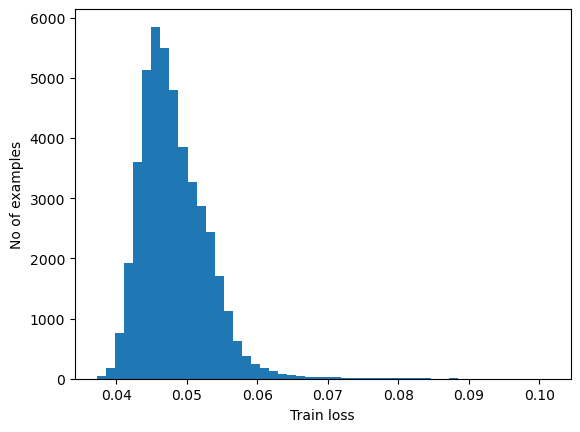

Wall time: 12.8 s


In [34]:
%%time
# 閾値の計算
S=0.5
train_anomaly_score =  test(encoder, generator, discriminator, train_dataset, Lambda=0)
THRESHOLD = np.mean(train_anomaly_score) + S*np.std(train_anomaly_score)
print("Threshold: ", THRESHOLD)

plt.hist(train_anomaly_score, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

## 評価

AU PR:0.6293062899799744


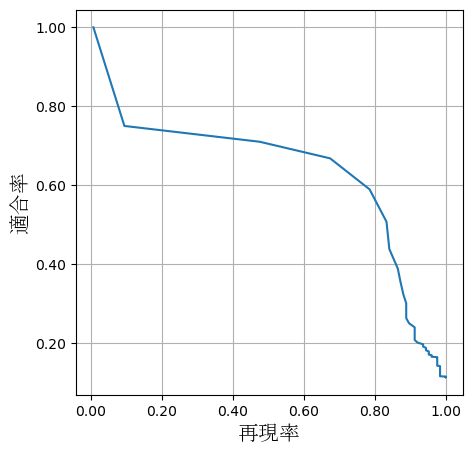

In [35]:
auPR, fig, thr_max_f_score, _ = validate.plot_PR(label_unit, anomaly_score, 100)
fig_PR = validate.plot_to_image(fig)
print(f"AU PR:{auPR}")

AU ROC:0.9590290166659041


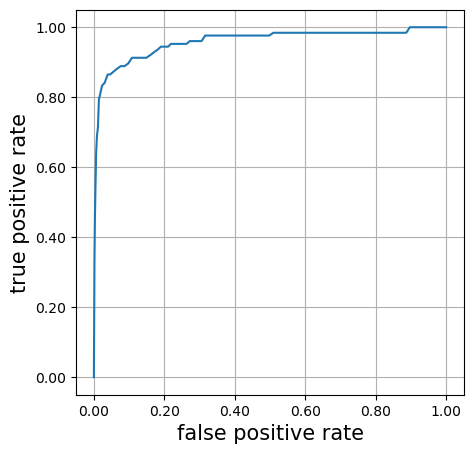

In [36]:
auROC, fig = validate.plot_ROC(label_unit, anomaly_score, 100)
fig_ROC = validate.plot_to_image(fig)
print(f"AU ROC:{auROC}")

In [37]:
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_metric("Threshold", THRESHOLD)
    
    mlflow.log_metric("AU PR", auPR)
    mlflow.log_metric("AU ROC", auROC)

    mlflow.log_image(fig_PR.numpy()[0], 'fig_PR.png')
    mlflow.log_image(fig_ROC.numpy()[0], 'fig_ROC.png')
########################

## 異常度可視化

In [41]:
start='2022-09-21 06:00:00'
end='2022-09-21 22:00:00'

uLimit=anomaly_score.max()

fig = visualization.plot_anomaly_score(start, end, DURATION, anomaly_score, label_unit, thr_max_f_score, uLimit)
fig_anomalyscore = visualization.plot_to_image(fig)

####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_image(fig_anomalyscore.numpy()[0], 'fig_anomalyscore.png')
########################

## 異常データの再構成可視化

In [42]:
def plot_spectrogram(x):
    fig, axes = plt.subplots(1, figsize=(12, 8))
    axes.imshow(x, origin='lower')
    axes.set_title('Spectrogram')
    
    return fig

npy_output: data_output\npy\abnormal\npy_files
data_output\npy\abnormalが既に存在します
data_output\npy\abnormalを削除します
data_output\npy\abnormal削除完了


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


Wall time: 8.22 s


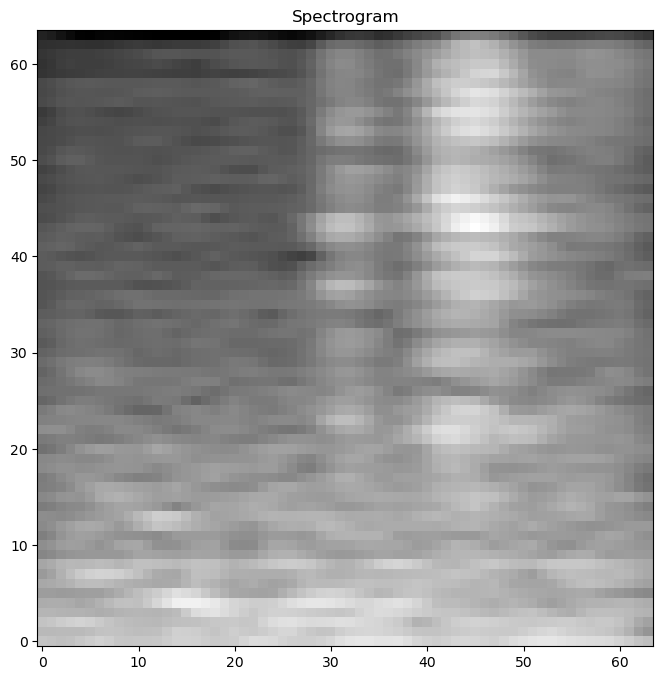

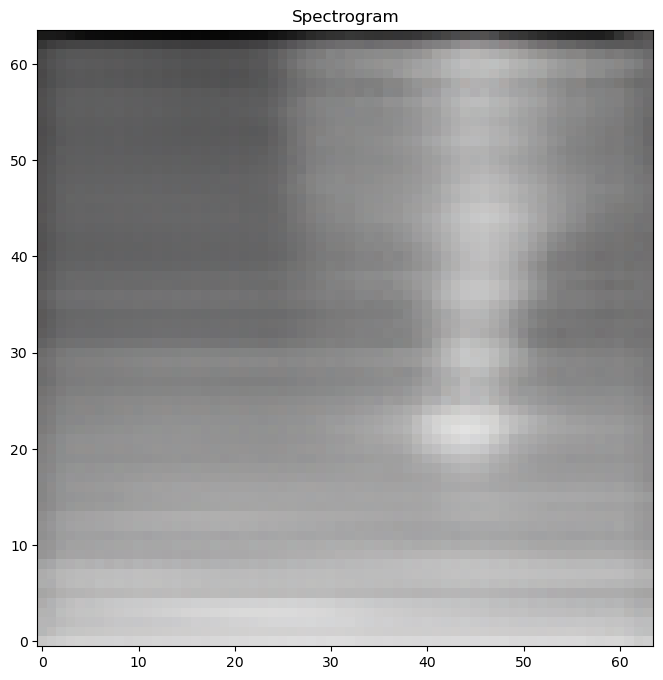

In [43]:
%%time
import tensorflow as tf

abnormal_wav = ["../../data/閾値に使用するデータ/wav_異常音/210922_0033/210922_0033_0;0;11-0;0;13.wav"]
abnormal_npy = "./data_output/npy/abnormal"

_, _ = wav_to_spectrogram(abnormal_npy, abnormal_wav, SR, DURATION, MEL_PAEAMS, overwrite=True)

list_abnormal_npyFiles = glob.glob(f'{abnormal_npy}/npy_files/*')
# データセット
abnormal_dataset = return_dataset_loader(list_abnormal_npyFiles,
                                      [IMAGE_SIZE[0], IMAGE_SIZE[1]],
                                      training=False, 
                                      mean=train_mean, 
                                      std=train_std, 
                                      batch_size=BATCH_SIZE)

for batch_x in abnormal_dataset.take(1):
    input_image = batch_x[0]
    fig = plot_spectrogram((input_image+1.0)/2.0)
    image_input = visualization.plot_to_image(fig)
    
    batch_image = tf.expand_dims(input_image,axis=0)
    
    training=False
    E_x = encoder(batch_image, training=training)
    G_E_x = generator(E_x, training=training)
    fig = plot_spectrogram((G_E_x[0]+1.0)/2.0)
    image_output = visualization.plot_to_image(fig)
    
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_image(image_input.numpy()[0], 'image_input.png')
    mlflow.log_image(image_output.numpy()[0], 'image_output.png')
########################